## Investigate a Dataset - European Soccer Database

## Data Set
European Soccer Database

## Overview and Notes
This soccer database comes from Kaggle and is well suited for data analysis and machine learning.  
It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016.  
This dataset is quite extensive, and we encourage you to read more about it here.  
The database is stored in a SQLite database. You can access database files using software like DB Browser.  
This dataset will help you get good practice with your SQL joins.  
Make sure to look at how the different tables relate to each other.  
Some column titles should be self-explanatory, and others you’ll have to look up on Kaggle.  

## Sources

http://www.numpy.org  

https://pandas.pydata.org  

http://pandas.pydata.org/pandas-docs/version/0.9.1/visualization.html  

https://matplotlib.org/gallery.html  

https://seaborn.pydata.org  

https://www.udacity.com/course/intro-to-programming-nanodegree--nd000  

https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True  

https://www.kaggle.com/hugomathien/soccer  

https://github.com/georgezoto/Intro-to-Programming-Nanodegree/tree/11c4af90bf4e344656b93272a670f1c27bc5970a/Specialization/Data%20Analysis/Investigate%20a%20Dataset%20-%20European%20Soccer%20Database  



## Example Questions
How many goals has each team scored home, away and total on each season?  
How many goals has each team allowed home, away and total on each season?  
How teams improved or deterioted over time and what teams improved or deterioted the most and the least in terms of goals scored or allowed over time?  
How many goals has each team allowed home, away and total, from other teams, over all seasons?  
Which players had the most penalties?  
What team attributes lead to the most victories?  

## Import data analysis modules

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

## Connect to local sqlite database with the following tables:  
## Country, League, Match, Player, Player_Attributes, Team, Team_Attributes

In [42]:
connection = sqlite3.connect('database.sqlite')

## Run any query, store and display results in a DataFrame
## Select Country, League, Date, Team Home, Team Away and final score for every match in the dataset that belongs to the Spanish LIGA BBVA league.

In [43]:
query = '''
select 
    Country.name as Country, 
    League.name as League, 
    Match.season as Season,
    date(Match.date) as Date,
    Team_home.team_long_name as Team_Home, 
    Team_away.team_long_name as Team_Away, 
    Match.home_team_goal as Team_Home_Goal, 
    Match.away_team_goal as Team_Away_Goal
from
    Country, League, Team as Team_home, Team as Team_away, Match
where
    Country.id = League.country_id AND
    Country.id = Match.country_id AND
    League.id = Match.league_id AND
    Team_home.team_api_id = Match.home_team_api_id AND
    Team_away.team_api_id = Match.away_team_api_id AND
    Country = 'England' AND
    League.name = 'England Premier League'
order by
    Match.date
-- limit 10;
'''

#Run query and store results in a dataframe
spain_liga_bbva_df = pd.read_sql(query,connection)

## Print dataframe columns

In [44]:
print(spain_liga_bbva_df.columns)

Index([u'Country', u'League', u'Season', u'Date', u'Team_Home', u'Team_Away',
       u'Team_Home_Goal', u'Team_Away_Goal'],
      dtype='object')


## Look at any game Team Barcelona has played in this dataset

In [45]:
#print df[df['Team_Home'].str.contains('Barcelona', case = False)]
fc_barcelona_df = spain_liga_bbva_df[(spain_liga_bbva_df['Team_Home'] == 'FC Barcelona') | (spain_liga_bbva_df['Team_Away'] == 'FC Barcelona')]
fc_barcelona_df.tail(10)

Empty DataFrame
Columns: [Country, League, Season, Date, Team_Home, Team_Away, Team_Home_Goal, Team_Away_Goal]
Index: []

## Create helpful funtions that will be used repeatedly for resetting an index of an input series, store result in a dataframe, pivot it  so that each Season is a seperate column and finally plot its input columns over its input index

In [46]:
"""
reset_index_pivot_stacked_bar_plot_series(Args) is used for resetting an index of an input series, store result in a dataframe, pivot it so that each Season is a seperate column and finally plot its input columns over its input index.

Args:
    plot_type: Type of chart plotted, 'stacked_bar' or 'heat_map' 
    season_team_scored_allowed_sum: input pandas Series containing Season, Team and sum of goals scored or allowed for each season 
    index: 'Team_Home' or 'Team_Away' or 'Team' index used for x label plotting
    columns: Columns to pivot resulting dataframe, usually 'Season', used as x label subplotting
    values: 'Team_Home_Goal' or 'Team_Away_Goal' or 'Team_Goal' or 'Team_Allowed' columns used as values of a plot
    title: Title of a plot
    xlabel: X axis label of a plot
    ylabel: Y axis label of a plot
    
Returns:
    Pivoted DataFrame with each Season in a seperate column.

Raises:
    None
"""
def reset_index_pivot_plot_series(plot_type, plot_color, season_team_scored_allowed_sum, \
    input_index, input_columns, input_values, title, xlabel, ylabel, reset_flag, pivot_flag):
    
    if reset_flag:
        #Reset index of series so 'Season' column is fully populated, store in pandas DataFrame
        season_team_scored_allowed_sum = season_team_scored_allowed_sum.reset_index()
    if pivot_flag:
        #Pivot dataframe so that each Season is a seperate column, needed for multi-series plots
        season_team_scored_allowed_sum = season_team_scored_allowed_sum.pivot(index=input_index, columns=input_columns, values=input_values)
    
    if plot_type == 'stacked_bar':
        #Plot a stacked bar of final DataFrame with details provided 
        season_team_scored_allowed_sum.plot(kind='bar', stacked=True, figsize=(20, 15))
    elif plot_type == 'heat_map':
        #Plot a heat map of final DataFrame with details provided 
        plt.subplots(figsize=(20,15))
        sns.heatmap(season_team_scored_allowed_sum, annot=True, cmap=plot_color)
    else:
        #Plot a stacked bar of final DataFrame with details provided 
        season_team_scored_allowed_sum.plot(kind='bar', stacked=True, figsize=(20, 15))
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    #Return final DataFrame
    return season_team_scored_allowed_sum

## Compute home and away goals scored per season and add them up, store in pandas Series

In [47]:
season_team_home_goal_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Home'])['Team_Home_Goal'].sum()
season_team_away_goal_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Away'])['Team_Away_Goal'].sum()
season_team_goal_sum = season_team_home_goal_sum + season_team_away_goal_sum
print type(season_team_home_goal_sum)
print season_team_home_goal_sum.head(30)

<class 'pandas.core.series.Series'>
Season     Team_Home           
2008/2009  Arsenal                 31
           Aston Villa             27
           Blackburn Rovers        22
           Bolton Wanderers        21
           Chelsea                 33
           Everton                 31
           Fulham                  28
           Hull City               18
           Liverpool               41
           Manchester City         40
           Manchester United       43
           Middlesbrough           17
           Newcastle United        24
           Portsmouth              26
           Stoke City              22
           Sunderland              21
           Tottenham Hotspur       21
           West Bromwich Albion    26
           West Ham United         23
           Wigan Athletic          17
2009/2010  Arsenal                 48
           Aston Villa             29
           Birmingham City         19
           Blackburn Rovers        28
           Bolton Wa

## Question 1a: How many goals has each team scored home on each season?  
## Answer 1a: Home goals scored per Season

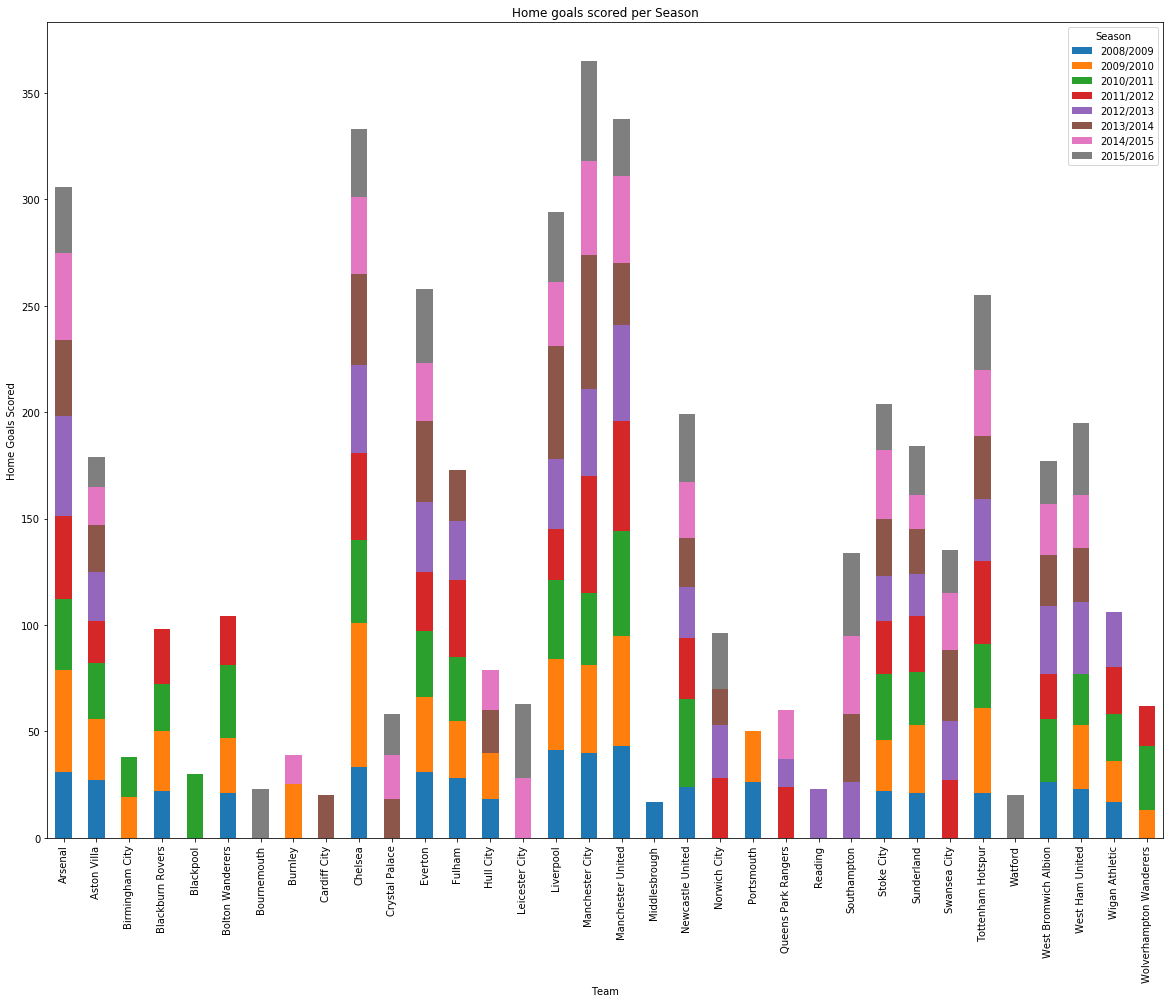

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team_Home                                                                 
Arsenal                31.0       48.0       33.0       39.0       47.0   
Aston Villa            27.0       29.0       26.0       20.0       23.0   
Birmingham City         NaN       19.0       19.0        NaN        NaN   
Blackburn Rovers       22.0       28.0       22.0       26.0        NaN   
Blackpool               NaN        NaN       30.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team_Home                                          
Arsenal                36.0       41.0       31.0  
Aston Villa            22.0       18.0       14.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [48]:
season_team_home_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', 'Home goals scored per Season', 'Team', 'Home Goals Scored', True, True)
season_team_home_goal_sum.head()

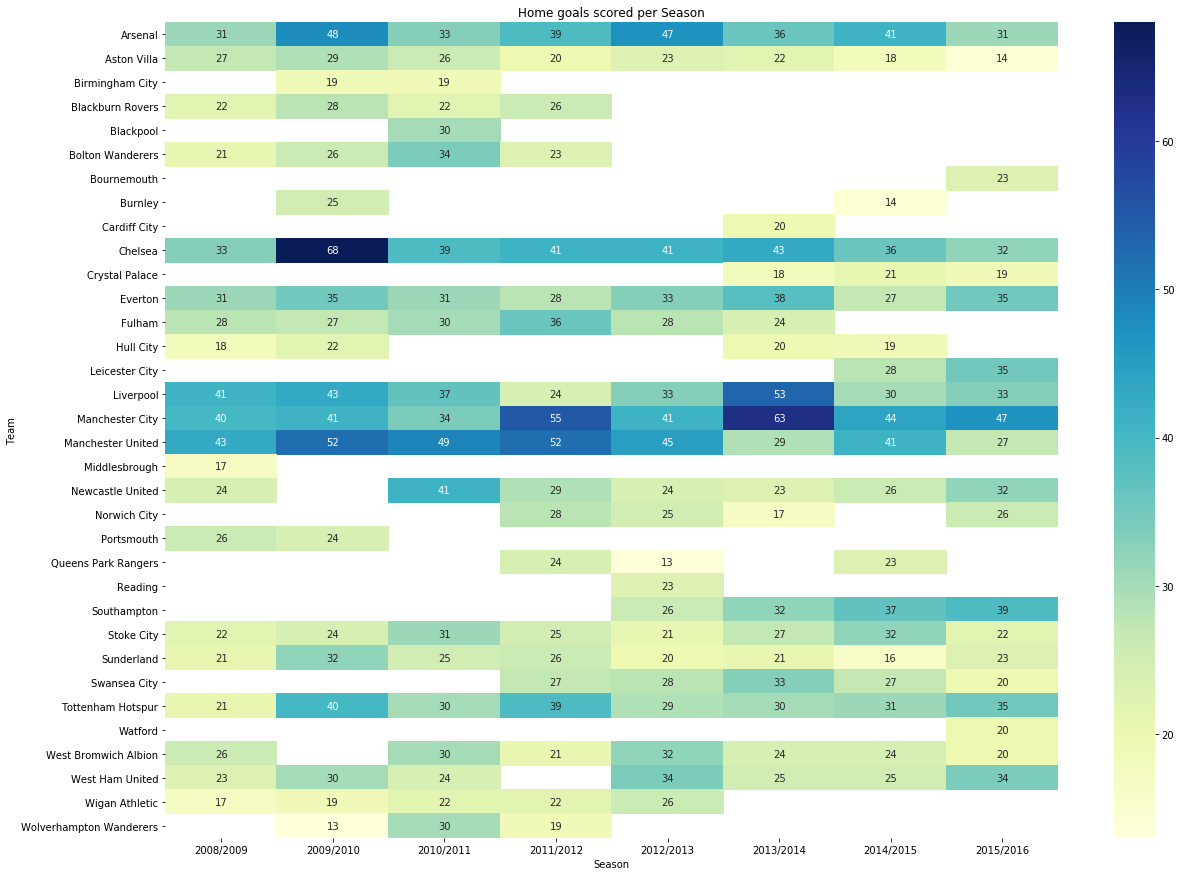

In [49]:
season_team_home_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', 'Home goals scored per Season', 'Season', 'Team', False, False)

## Question 1b: How teams improved over time and what teams improved the most and the least in terms of goals scored home over time?
## Answer 1b: Home goals scored over Seasons

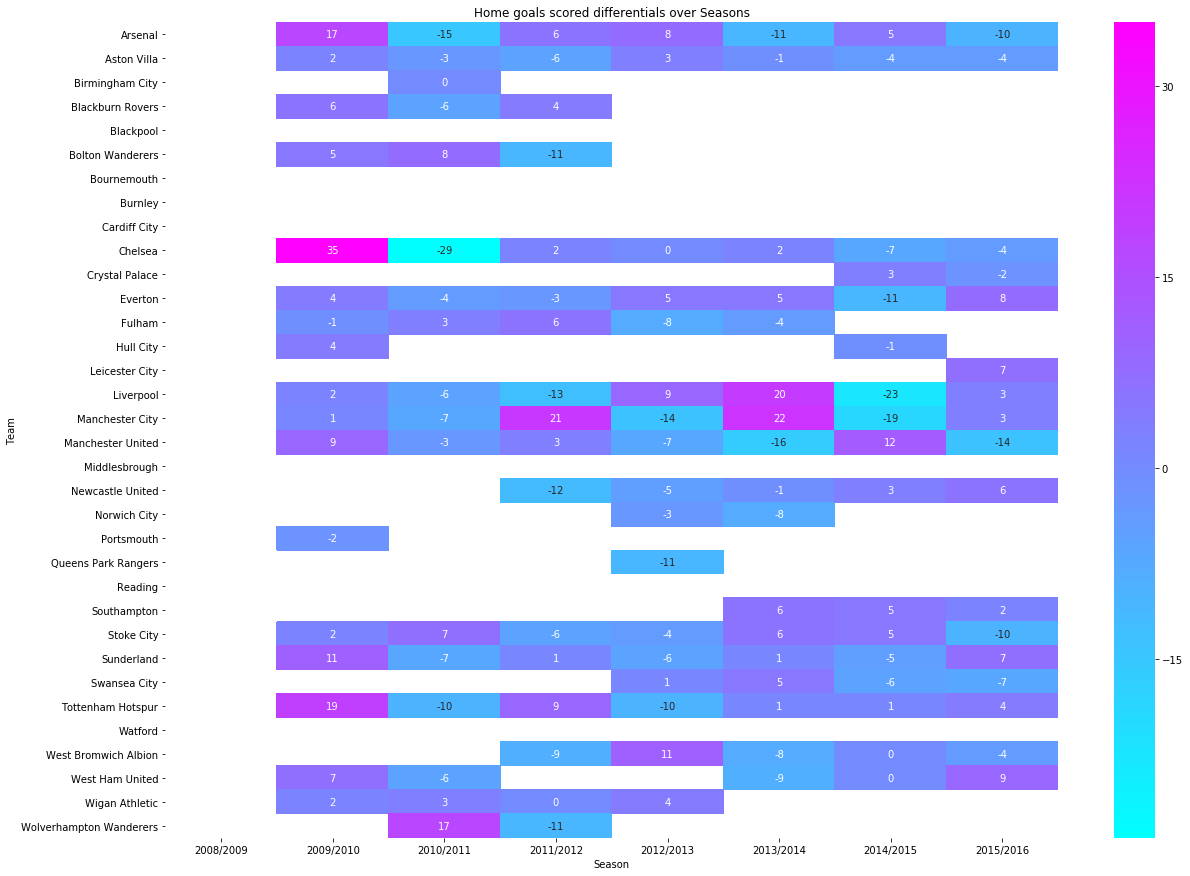

In [50]:
season_team_home_goal_sum_diff = season_team_home_goal_sum.diff(periods=1, axis='columns')

season_team_home_goal_sum_diff = reset_index_pivot_plot_series('heat_map', 'cool', season_team_home_goal_sum_diff, \
    'Team_Home', 'Season', 'Team_Home_Goal', 'Home goals scored differentials over Seasons', 'Season', 'Team', False, False)

## Question 2a: How many goals has each team scored away on each season?  
## Answer 2a: Away goals scored per Season

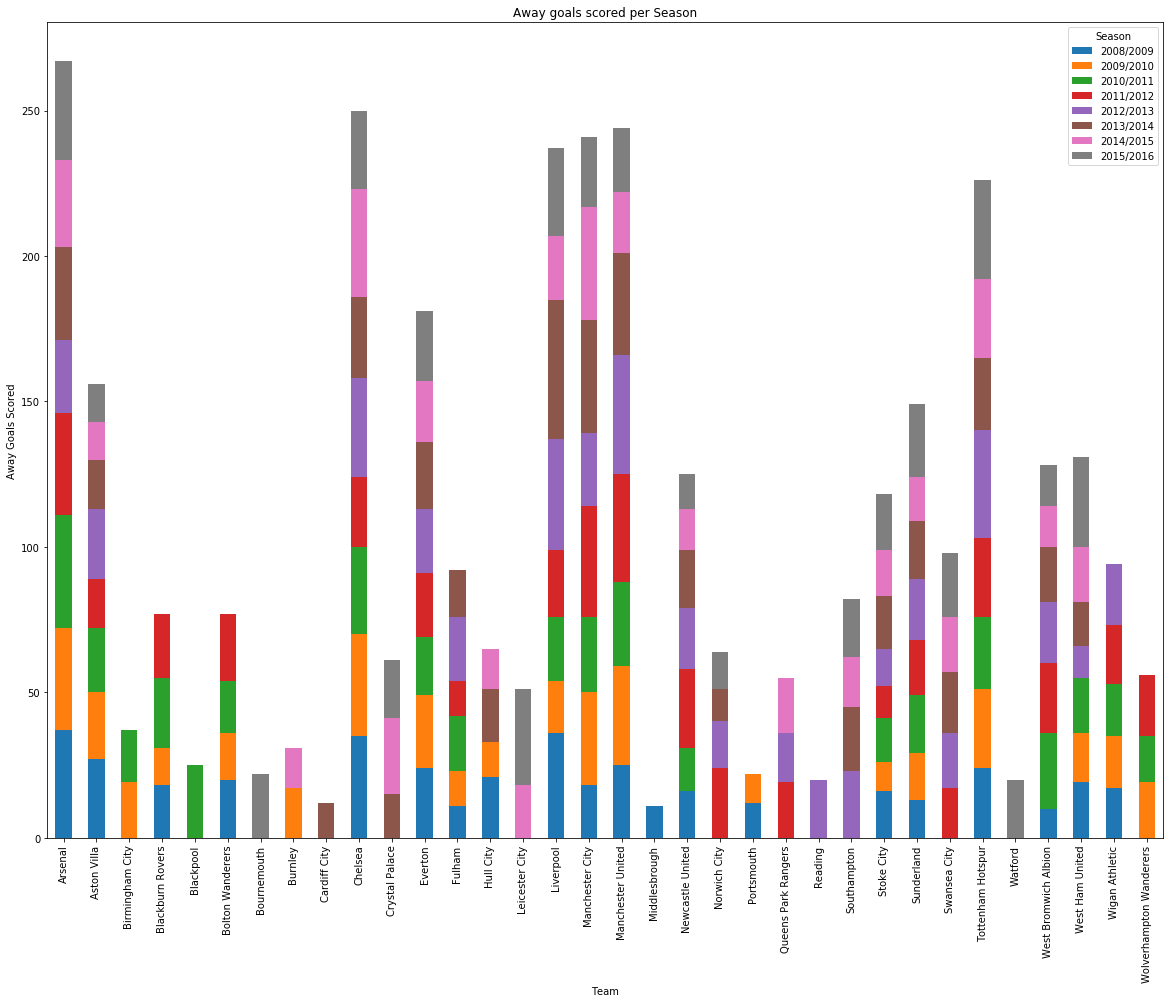

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team_Away                                                                 
Arsenal                37.0       35.0       39.0       35.0       25.0   
Aston Villa            27.0       23.0       22.0       17.0       24.0   
Birmingham City         NaN       19.0       18.0        NaN        NaN   
Blackburn Rovers       18.0       13.0       24.0       22.0        NaN   
Blackpool               NaN        NaN       25.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team_Away                                          
Arsenal                32.0       30.0       34.0  
Aston Villa            17.0       13.0       13.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [51]:
season_team_away_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_away_goal_sum, \
    'Team_Away', 'Season', 'Team_Away_Goal', 'Away goals scored per Season', 'Team', 'Away Goals Scored', True, True)
season_team_away_goal_sum.head()

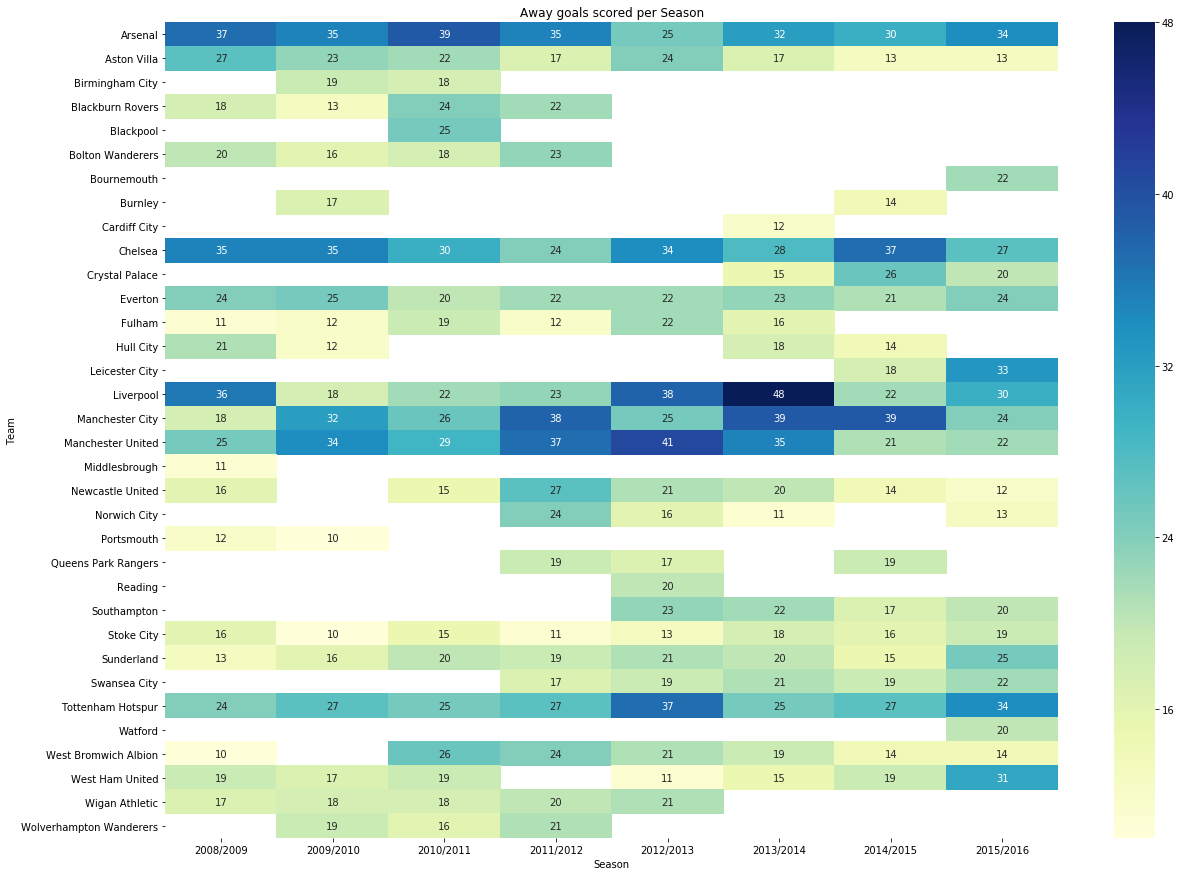

In [52]:
season_team_away_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_away_goal_sum, \
    'Team_Away', 'Season', 'Team_Away_Goal', 'Away goals scored per Season', 'Season', 'Team', False, False)

## Question 2b: How teams improved over time and what teams improved the most and the least in terms of goals scored away over time?
## Answer 2b: Away goals scored over Seasons

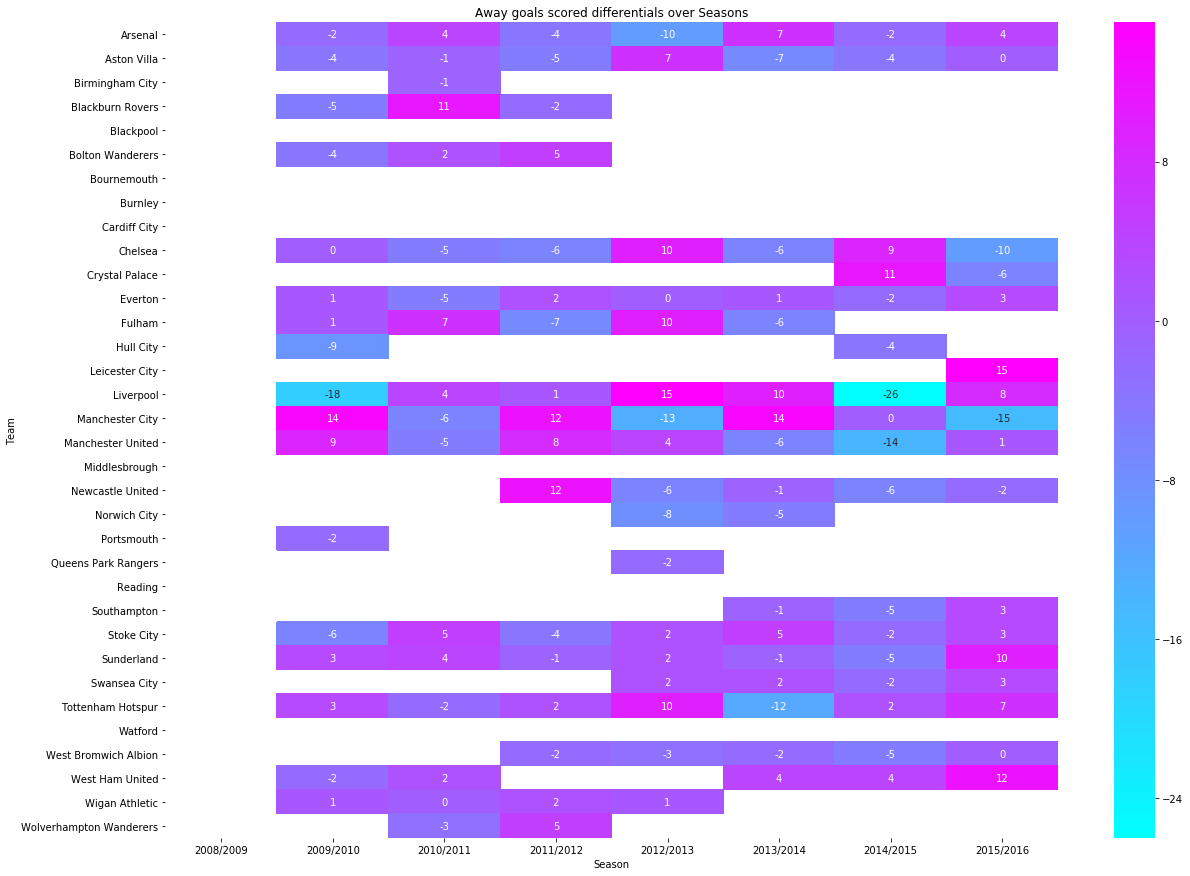

In [53]:
season_team_away_goal_sum_diff = season_team_away_goal_sum.diff(periods=1, axis='columns')

season_team_away_goal_sum_diff = reset_index_pivot_plot_series('heat_map', 'cool', season_team_away_goal_sum_diff, \
    'Team_Away', 'Season', 'Team_Away_Goal', 'Away goals scored differentials over Seasons', 'Season', 'Team', False, False)

## Question 3a: How many goals has each team scored on each season?  
## Answer 3a: Total goals scored per Season

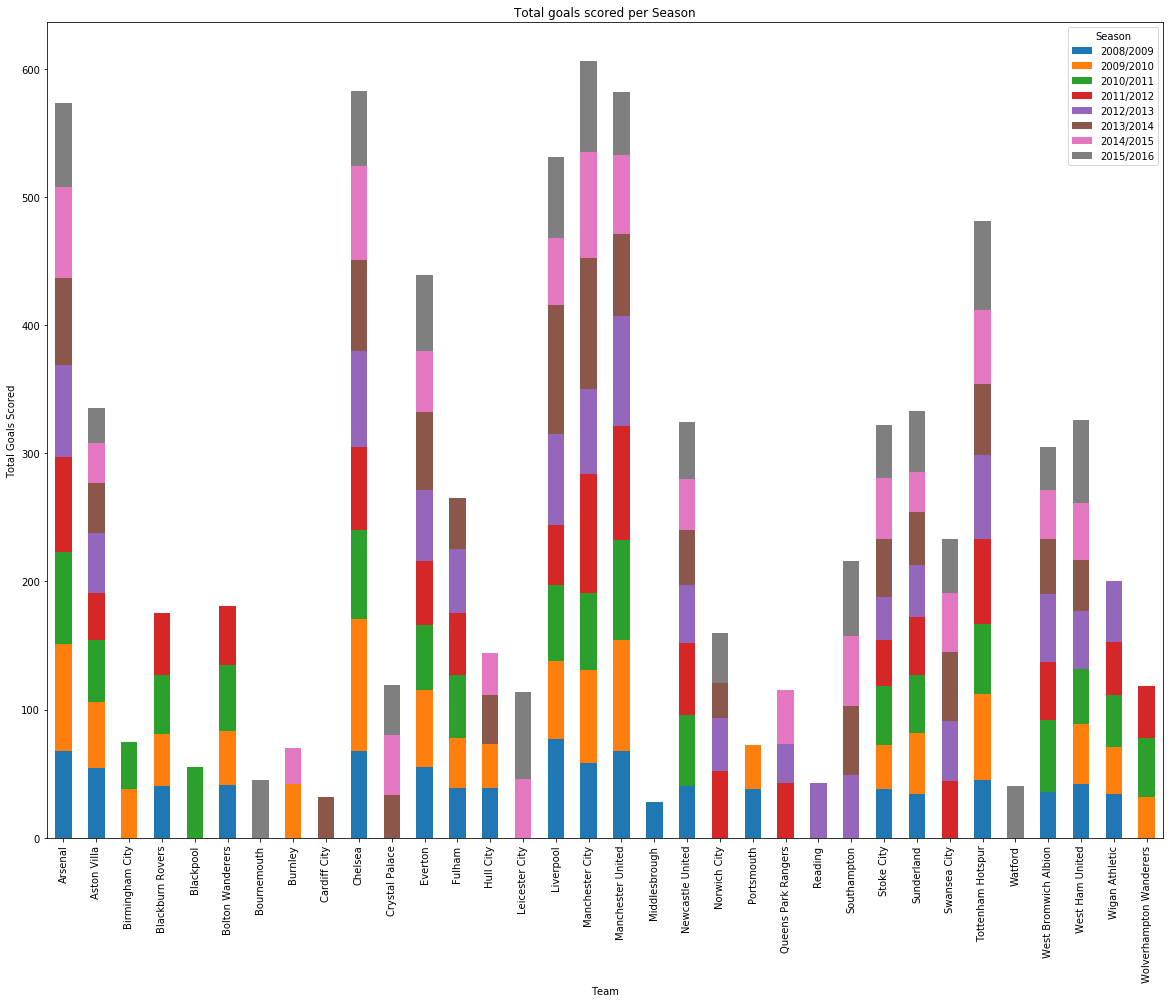

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team                                                                      
Arsenal                68.0       83.0       72.0       74.0       72.0   
Aston Villa            54.0       52.0       48.0       37.0       47.0   
Birmingham City         NaN       38.0       37.0        NaN        NaN   
Blackburn Rovers       40.0       41.0       46.0       48.0        NaN   
Blackpool               NaN        NaN       55.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team                                               
Arsenal                68.0       71.0       65.0  
Aston Villa            39.0       31.0       27.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [54]:
season_team_goal_sum = season_team_goal_sum.reset_index()
season_team_goal_sum.rename(columns={'Season': 'Season', 'Team_Home': 'Team', 0: 'Team_Goal'}, inplace=True)

season_team_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_goal_sum, \
    'Team', 'Season', 'Team_Goal', 'Total goals scored per Season', 'Team', 'Total Goals Scored', False, True)
season_team_goal_sum.head()

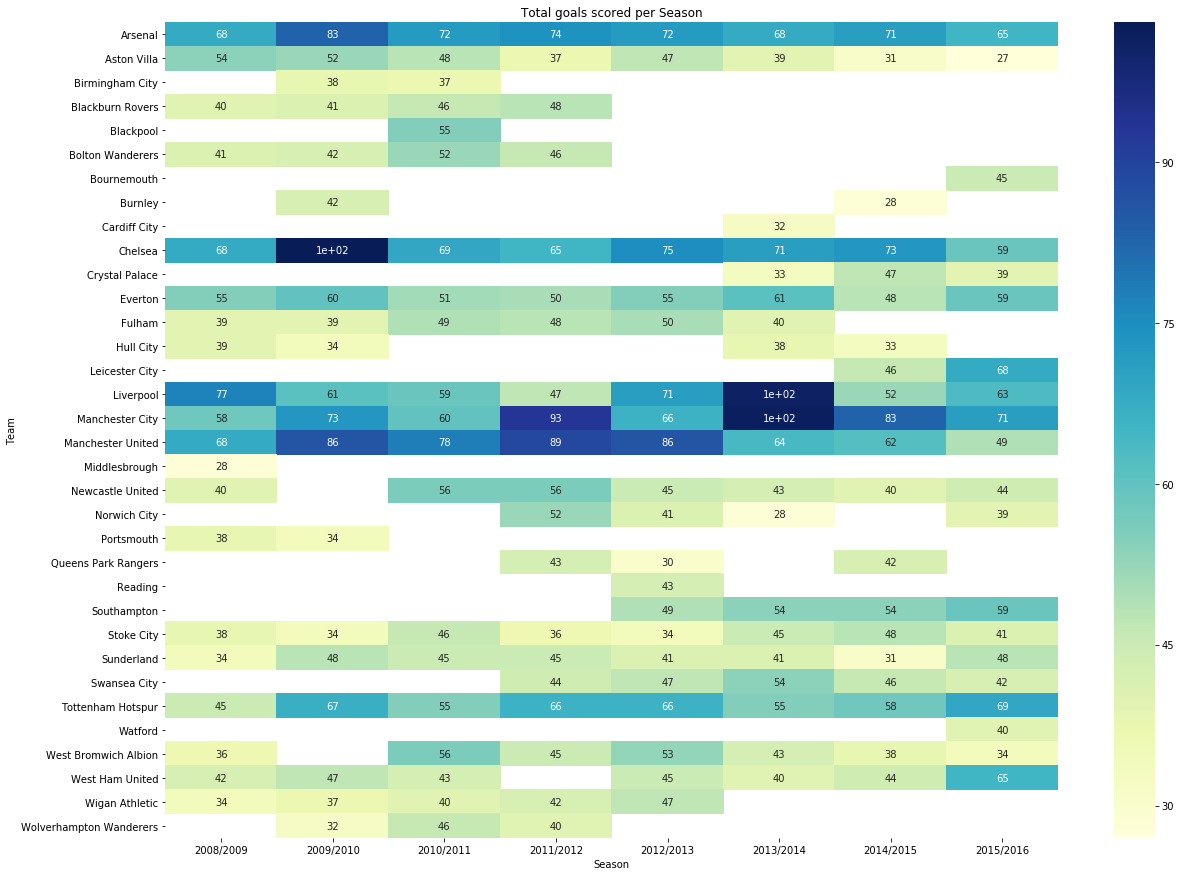

In [55]:
season_team_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_goal_sum, \
    'Team', 'Season', 'Team_Goal', 'Total goals scored per Season', 'Season', 'Team', False, False)

## Question 3b: How teams improved over time and what teams improved the most and the least in terms of total goals scored over time?
## Answer 3b: Total goals scored over Seasons

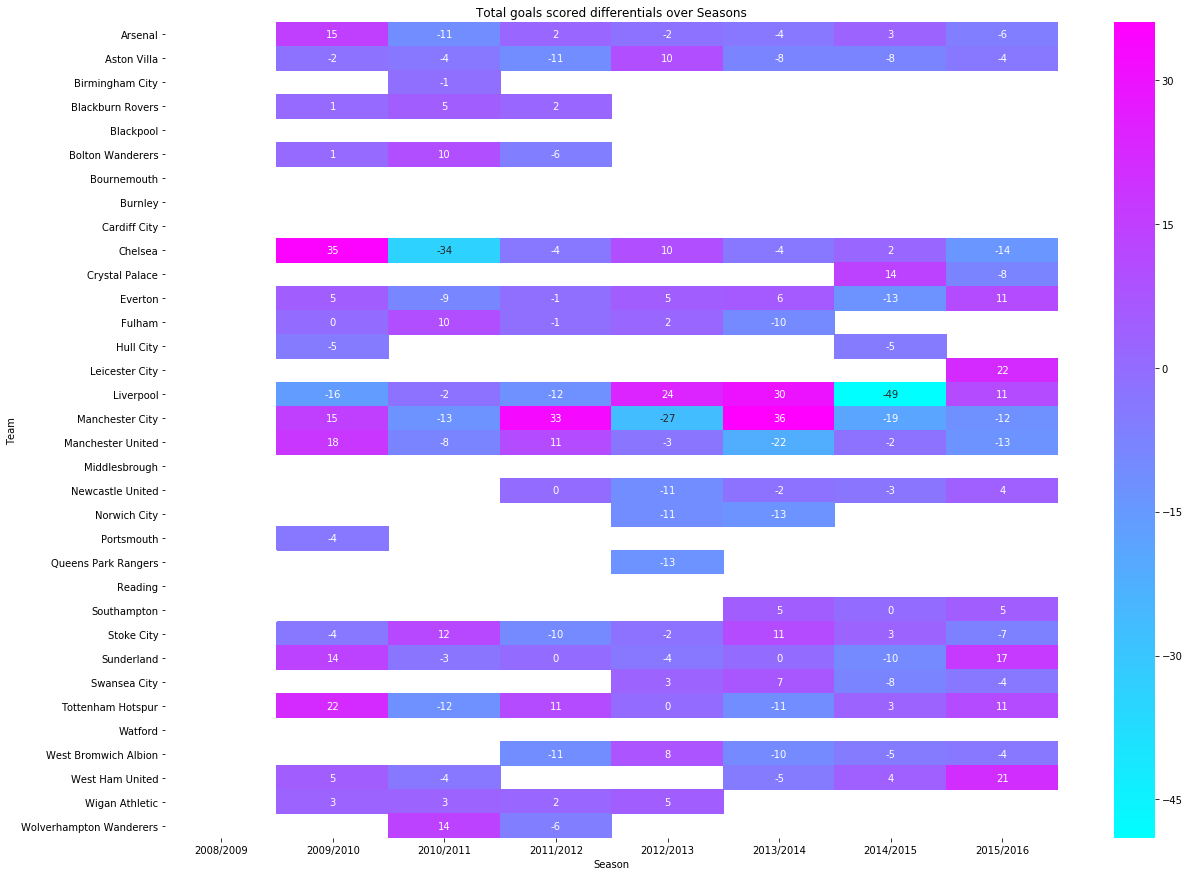

In [56]:
season_team_goal_sum_diff = season_team_goal_sum.diff(periods=1, axis='columns')

season_team_goal_sum_diff = reset_index_pivot_plot_series('heat_map', 'cool', season_team_goal_sum_diff, \
    'Team', 'Season', 'Team_Goal', 'Total goals scored differentials over Seasons', 'Season', 'Team', False, False)

## Compute home and away goals allowed per season and add them up, store in pandas Series

In [57]:
season_team_home_allowed_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Home'])['Team_Away_Goal'].sum()
season_team_away_allowed_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Away'])['Team_Home_Goal'].sum()
season_team_allowed_sum = season_team_home_allowed_sum + season_team_away_allowed_sum
print type(season_team_home_allowed_sum)
print season_team_home_allowed_sum.head(30)

<class 'pandas.core.series.Series'>
Season     Team_Home           
2008/2009  Arsenal                 16
           Aston Villa             21
           Blackburn Rovers        23
           Bolton Wanderers        21
           Chelsea                 12
           Everton                 20
           Fulham                  16
           Hull City               36
           Liverpool               13
           Manchester City         18
           Manchester United       13
           Middlesbrough           20
           Newcastle United        29
           Portsmouth              29
           Stoke City              15
           Sunderland              25
           Tottenham Hotspur       10
           West Bromwich Albion    33
           West Ham United         22
           Wigan Athletic          18
2009/2010  Arsenal                 15
           Aston Villa             16
           Birmingham City         13
           Blackburn Rovers        18
           Bolton Wa

## Question 4a: How many goals has each team allowed home on each season?  
## Answer 4a: Home goals allowed per Season

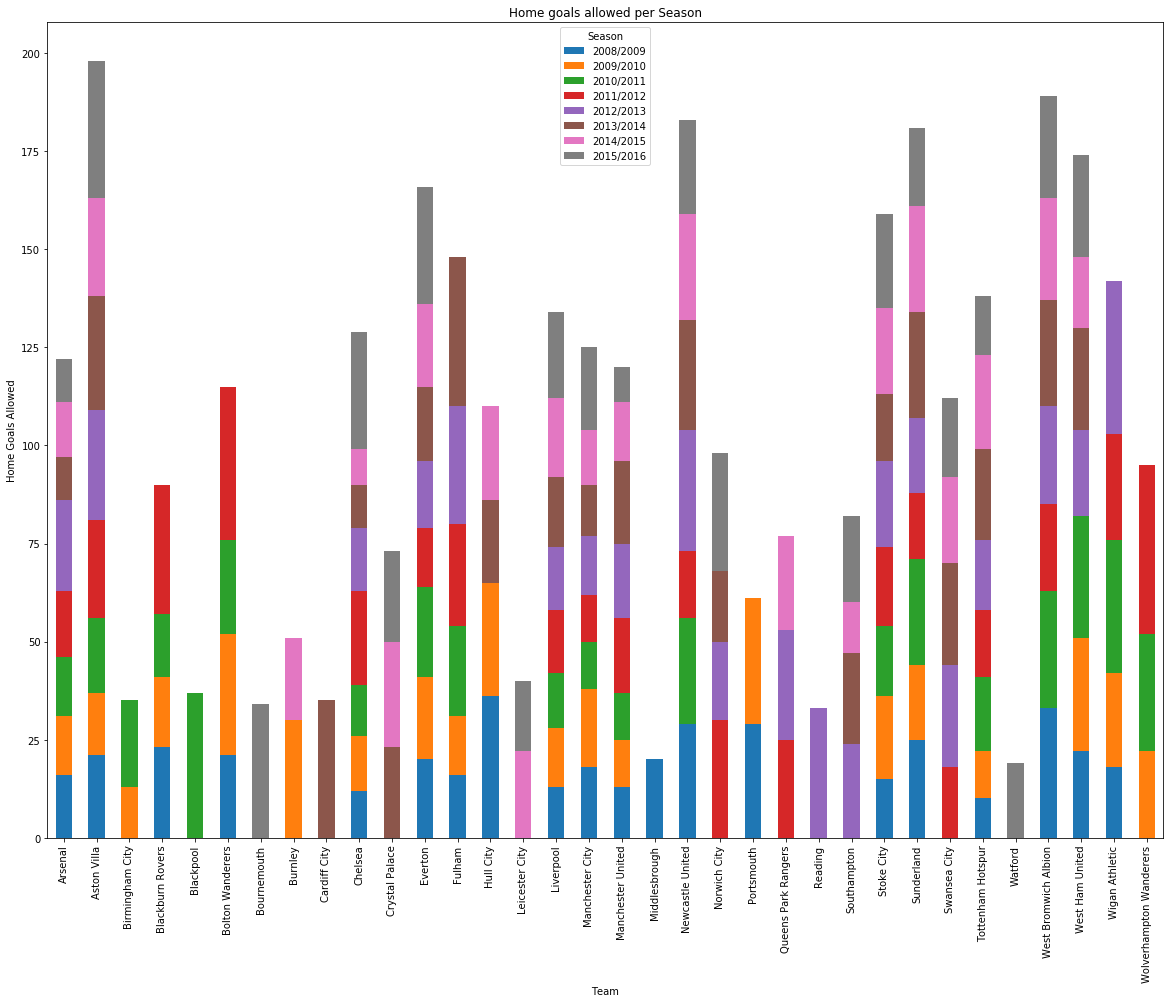

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team_Home                                                                 
Arsenal                16.0       15.0       15.0       17.0       23.0   
Aston Villa            21.0       16.0       19.0       25.0       28.0   
Birmingham City         NaN       13.0       22.0        NaN        NaN   
Blackburn Rovers       23.0       18.0       16.0       33.0        NaN   
Blackpool               NaN        NaN       37.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team_Home                                          
Arsenal                11.0       14.0       11.0  
Aston Villa            29.0       25.0       35.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [58]:
season_team_home_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_home_allowed_sum, \
    'Team_Home', 'Season', 'Team_Away_Goal', 'Home goals allowed per Season', 'Team', 'Home Goals Allowed', True, True)
season_team_home_allowed_sum.head()

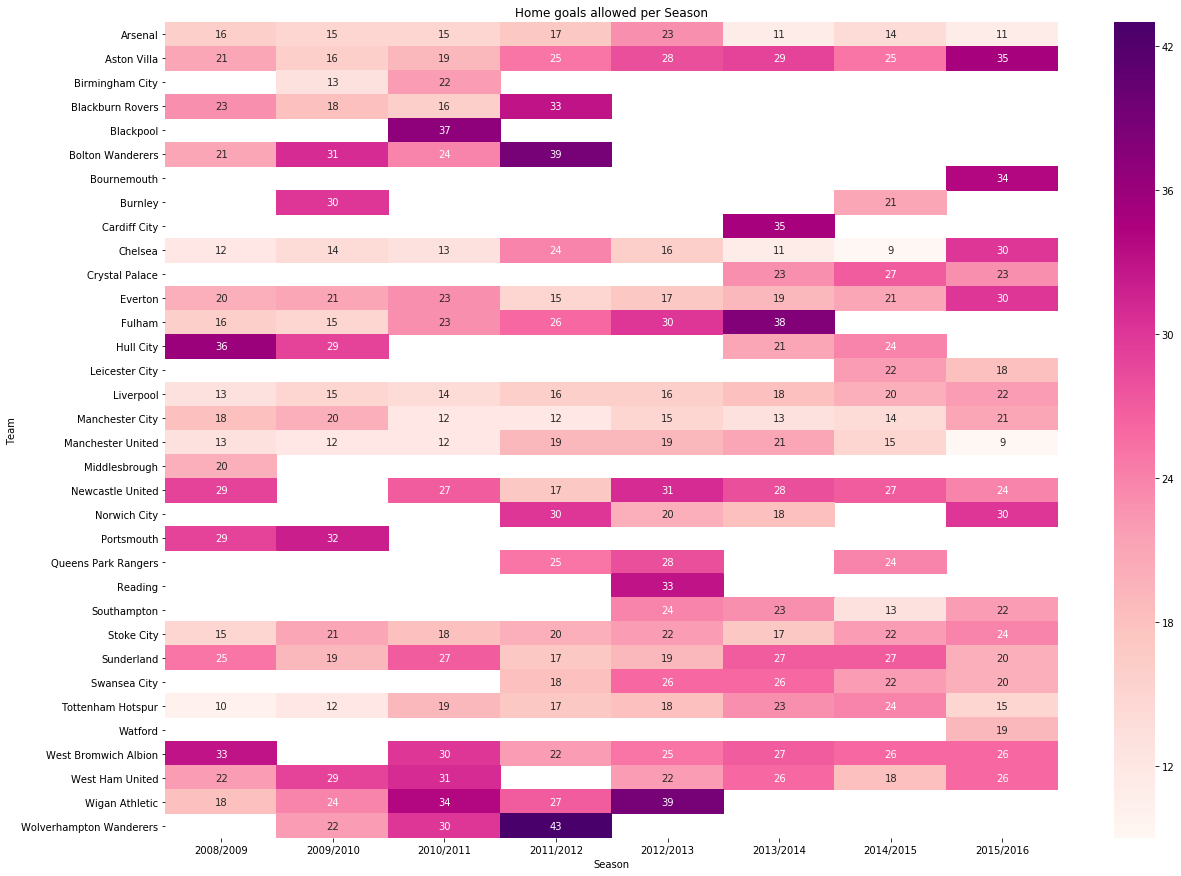

In [59]:
season_team_home_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_home_allowed_sum, \
    'Team_Home', 'Season', 'Team_Away_Goal', 'Home goals allowed per Season', 'Season', 'Team', False, False)

## Question 4b: How teams deteriorated over time and what teams deteriorated the most and the least in terms of goals allowed home over time?
## Answer 4b: Home goals allowed over Seasons

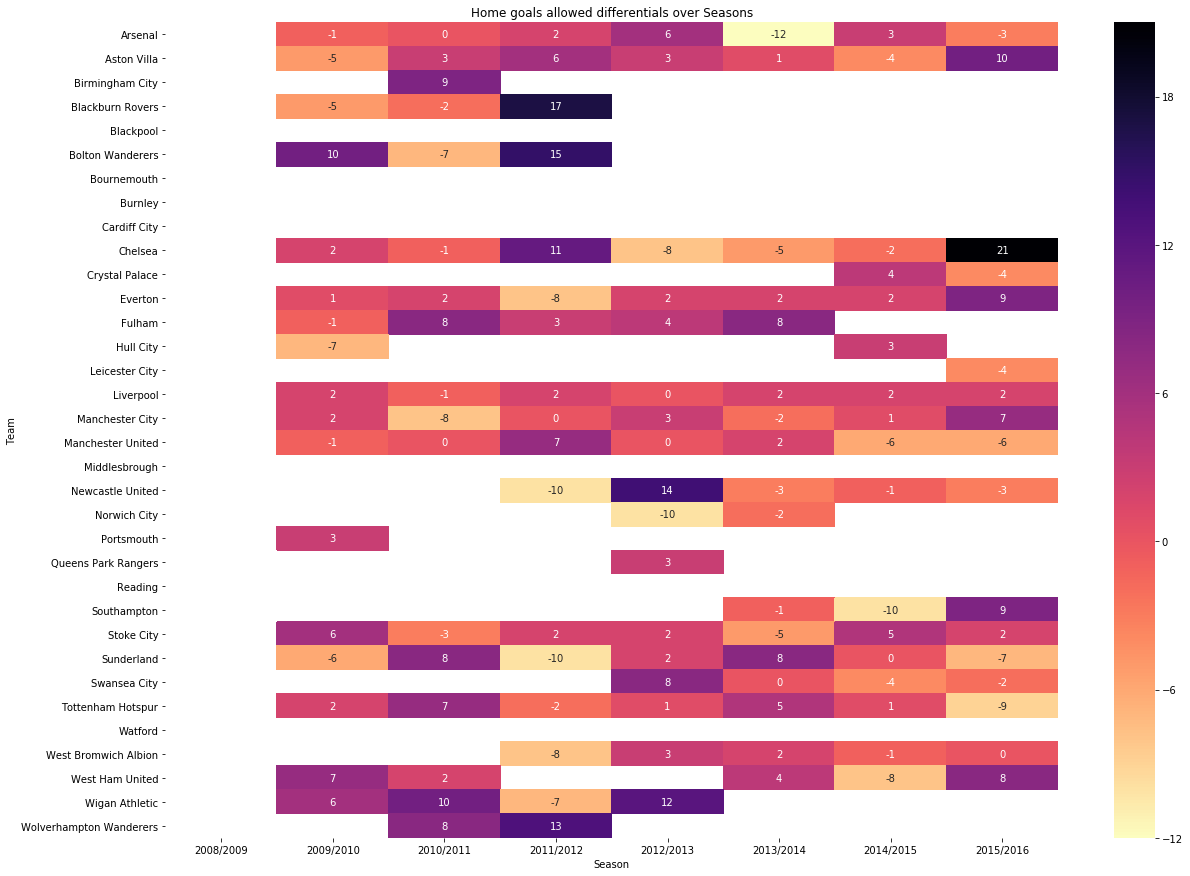

In [60]:
season_team_home_allowed_sum_diff = season_team_home_allowed_sum.diff(periods=1, axis='columns')

season_team_home_allowed_sum_diff = reset_index_pivot_plot_series('heat_map', 'magma_r', season_team_home_allowed_sum_diff, \
    'Team_Home', 'Season', 'Team_Away_Goal', 'Home goals allowed differentials over Seasons', 'Season', 'Team', False, False)

## Question 5a: How many goals has each team allowed away on each season?
## Answer 5a: Away goals allowed per Season

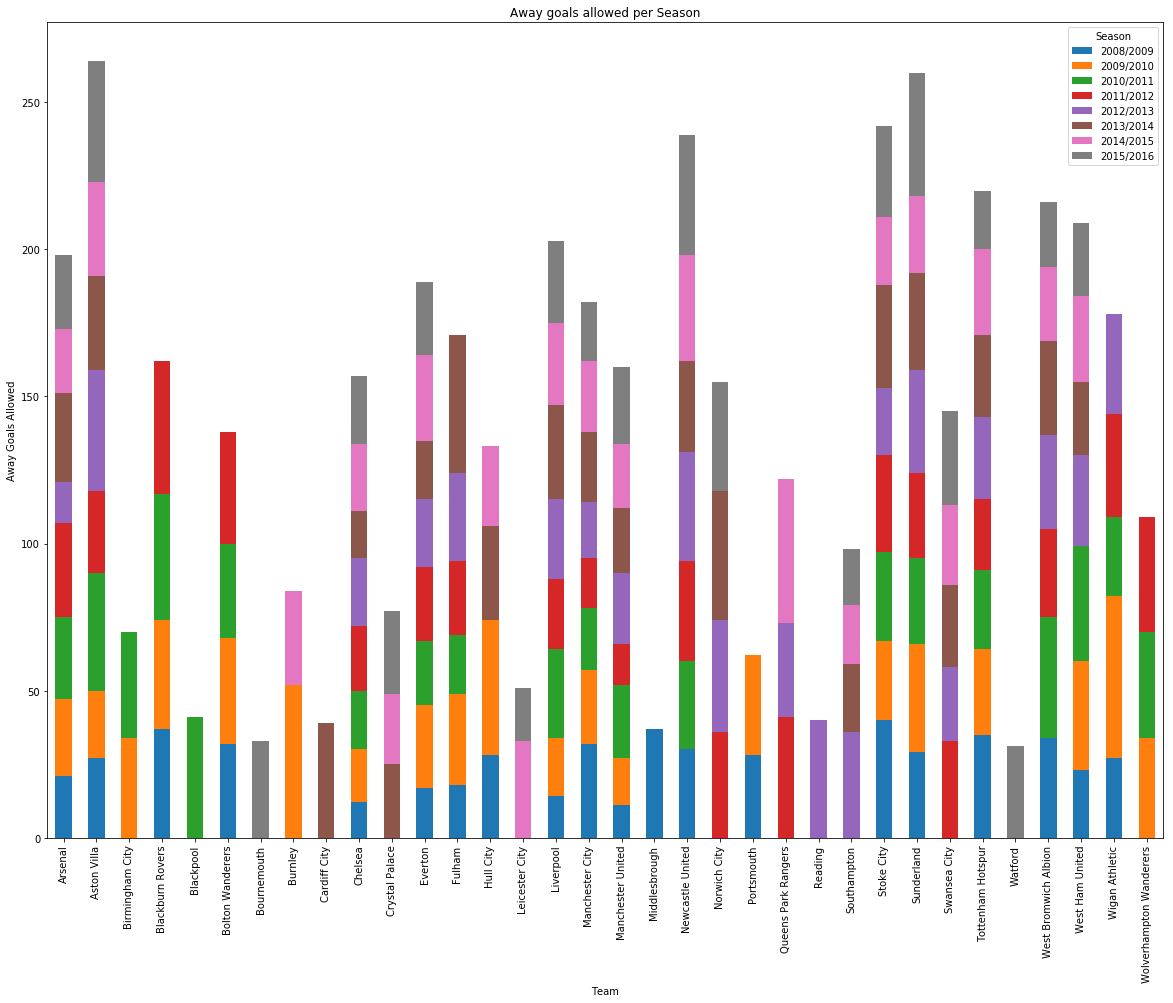

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team_Away                                                                 
Arsenal                21.0       26.0       28.0       32.0       14.0   
Aston Villa            27.0       23.0       40.0       28.0       41.0   
Birmingham City         NaN       34.0       36.0        NaN        NaN   
Blackburn Rovers       37.0       37.0       43.0       45.0        NaN   
Blackpool               NaN        NaN       41.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team_Away                                          
Arsenal                30.0       22.0       25.0  
Aston Villa            32.0       32.0       41.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [61]:
season_team_away_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_away_allowed_sum, \
    'Team_Away', 'Season', 'Team_Home_Goal', 'Away goals allowed per Season', 'Team', 'Away Goals Allowed', True, True)
season_team_away_allowed_sum.head()

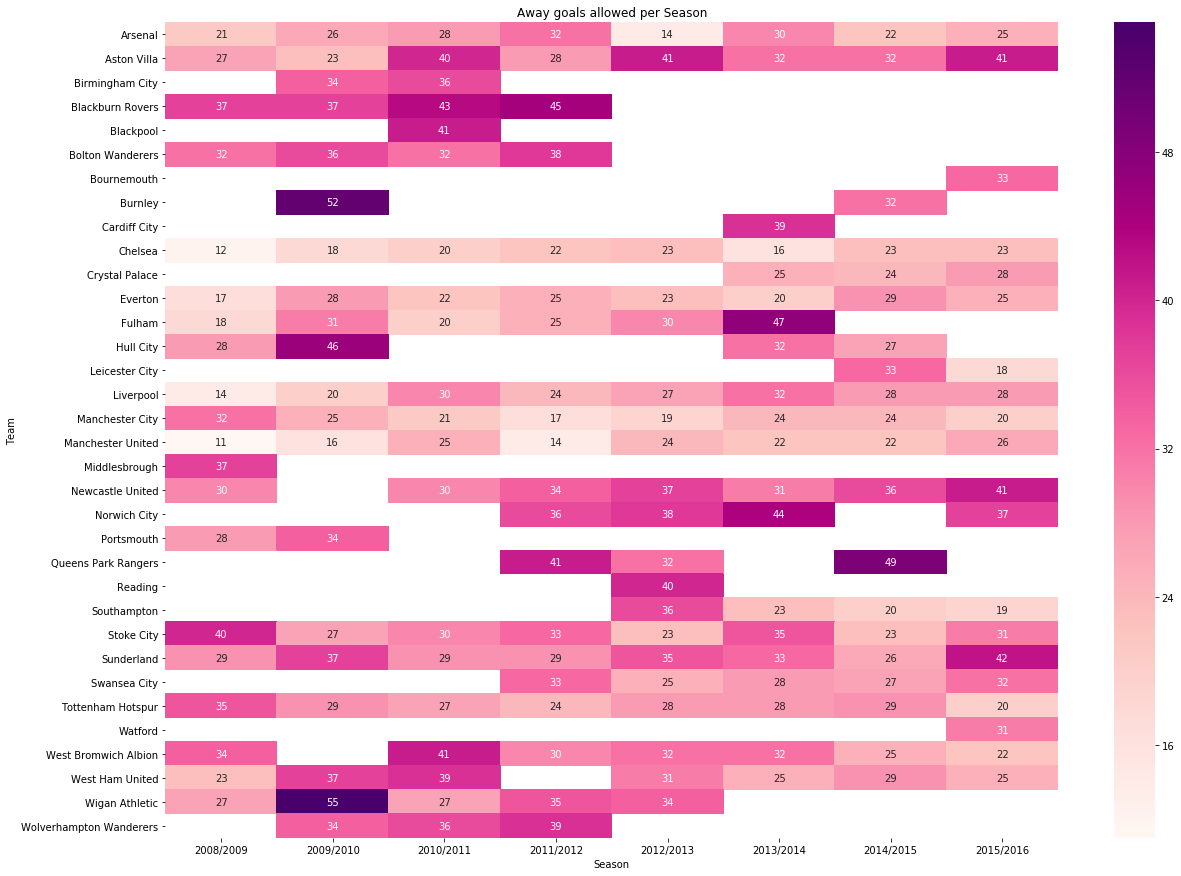

In [62]:
season_team_away_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_away_allowed_sum, \
    'Team_Away', 'Season', 'Team_Home_Goal', 'Away goals allowed per Season', 'Season', 'Team', False, False)

## Question 5b: How teams deteriorated over time and what teams deteriorated the most and the least in terms of goals allowed away over time?
## Answer 5b: Away goals allowed over Seasons

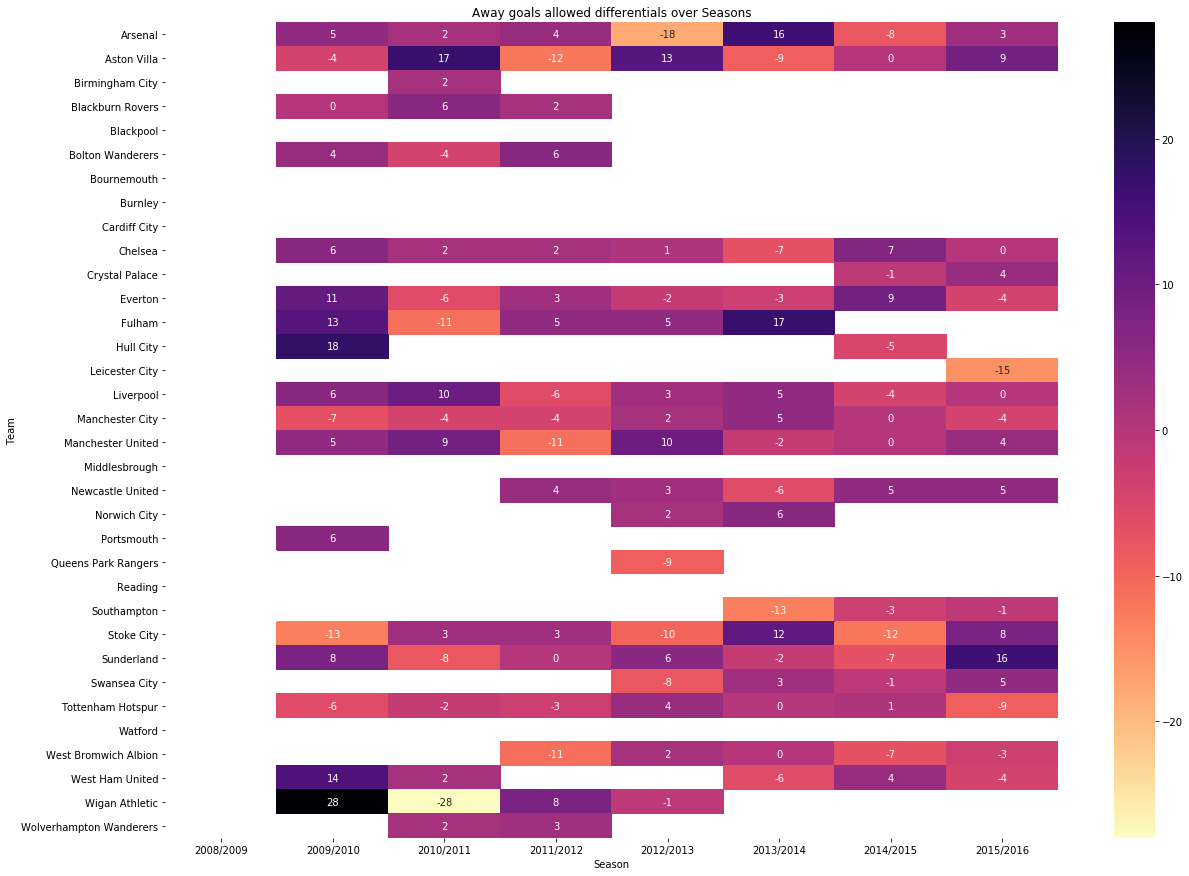

In [63]:
season_team_away_allowed_sum_diff = season_team_away_allowed_sum.diff(periods=1, axis='columns')

season_team_away_allowed_sum_diff = reset_index_pivot_plot_series('heat_map', 'magma_r', season_team_away_allowed_sum_diff, \
    'Team_Away', 'Season', 'Team_Home_Goal', 'Away goals allowed differentials over Seasons', 'Season', 'Team', False, False)

## Question 6a: How many goals has each team allowed on each season?
## Answer 6a: Total goals allowed per Season

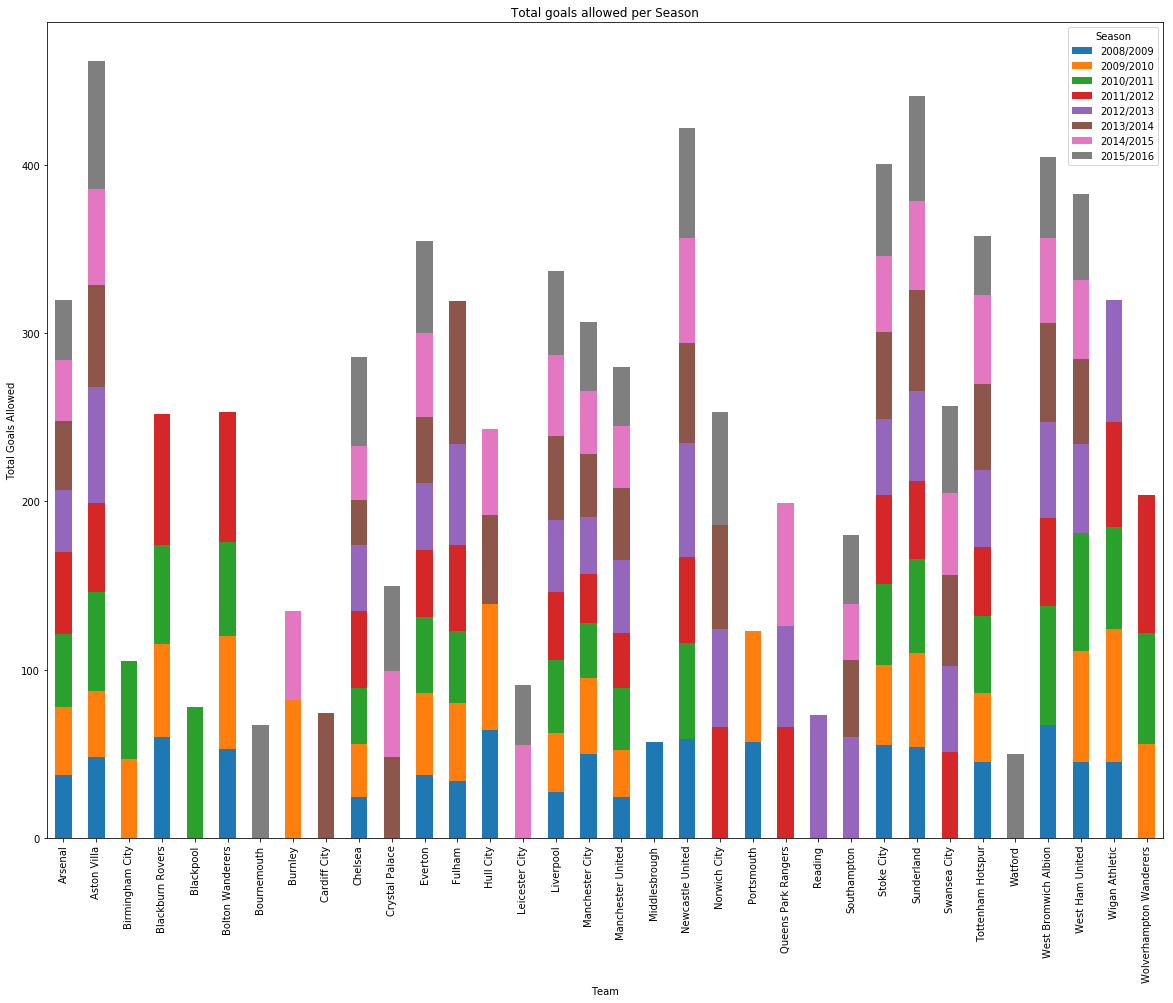

Season            2008/2009  2009/2010  2010/2011  2011/2012  2012/2013  \
Team                                                                      
Arsenal                37.0       41.0       43.0       49.0       37.0   
Aston Villa            48.0       39.0       59.0       53.0       69.0   
Birmingham City         NaN       47.0       58.0        NaN        NaN   
Blackburn Rovers       60.0       55.0       59.0       78.0        NaN   
Blackpool               NaN        NaN       78.0        NaN        NaN   

Season            2013/2014  2014/2015  2015/2016  
Team                                               
Arsenal                41.0       36.0       36.0  
Aston Villa            61.0       57.0       76.0  
Birmingham City         NaN        NaN        NaN  
Blackburn Rovers        NaN        NaN        NaN  
Blackpool               NaN        NaN        NaN

In [64]:
season_team_allowed_sum = season_team_allowed_sum.reset_index()
season_team_allowed_sum.rename(columns={'Season': 'Season', 'Team_Home': 'Team', 0: 'Team_Allowed'}, inplace=True)

season_team_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_allowed_sum, \
    'Team', 'Season', 'Team_Allowed', 'Total goals allowed per Season', 'Team', 'Total Goals Allowed', False, True)
season_team_allowed_sum.head()

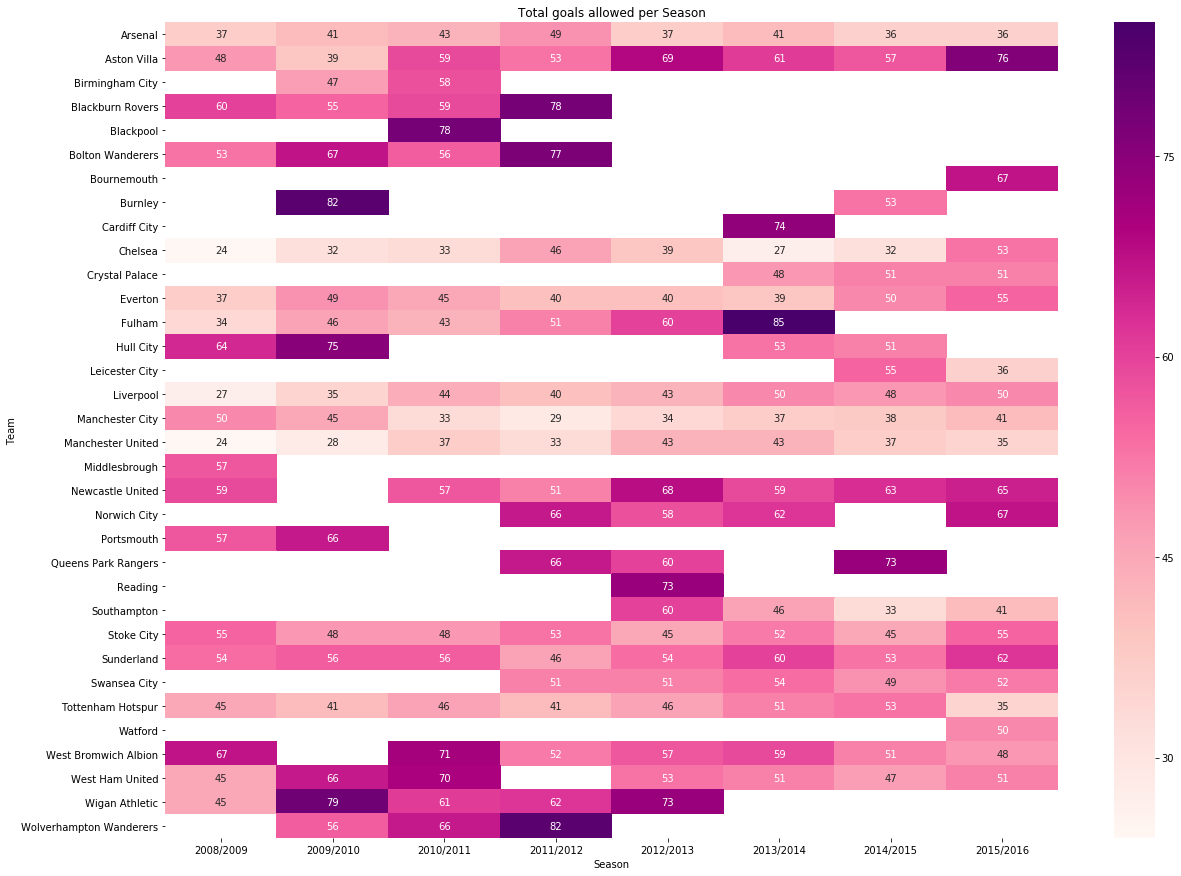

In [65]:
season_team_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_allowed_sum, \
    'Team', 'Season', 'Team_Allowed', 'Total goals allowed per Season', 'Season', 'Team', False, False)

## Question 6b: How teams deteriorated over time and what teams deteriorated the most and the least in terms of goals allowed over time?
## Answer 6b: Total goals allowed over Seasons

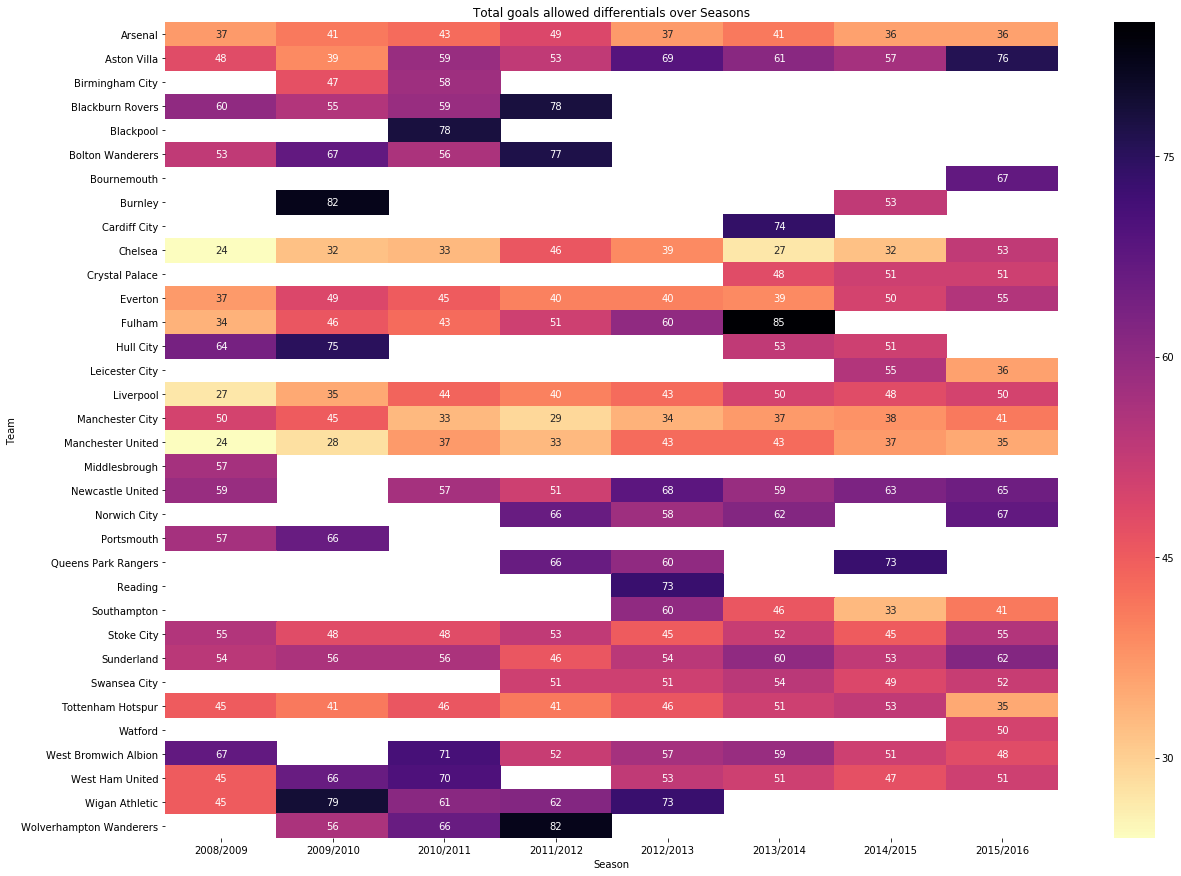

In [66]:
season_team_allowed_sum_diff = season_team_allowed_sum.diff(periods=1, axis='columns')

season_team_allowed_sum = reset_index_pivot_plot_series('heat_map', 'magma_r', season_team_allowed_sum, \
    'Team', 'Season', 'Team_Allowed', 'Total goals allowed differentials over Seasons', 'Season', 'Team', False, False)

## Team matches statistics and forecasts/projections

## Compute number of unique seasons

In [67]:
unique_seasons = pd.Series(spain_liga_bbva_df['Season'].unique())

## A reminder of the structure of our original spain_liga_bbva_df DataFrame

In [68]:
spain_liga_bbva_df.head()

Country                  League     Season        Date        Team_Home  \
0  England  England Premier League  2008/2009  2008-08-16          Arsenal   
1  England  England Premier League  2008/2009  2008-08-16       Sunderland   
2  England  England Premier League  2008/2009  2008-08-16  West Ham United   
3  England  England Premier League  2008/2009  2008-08-16          Everton   
4  England  England Premier League  2008/2009  2008-08-16    Middlesbrough   

              Team_Away  Team_Home_Goal  Team_Away_Goal  
0  West Bromwich Albion               1               0  
1             Liverpool               0               1  
2        Wigan Athletic               2               1  
3      Blackburn Rovers               2               3  
4     Tottenham Hotspur               2               1

## Group original spain_liga_bbva_df DataFrame by Team_Home and Team_Away goals scored and allowed

In [69]:
team_match_goal_sum = spain_liga_bbva_df.groupby(['Team_Home', 'Team_Away'])['Team_Home_Goal', 'Team_Away_Goal'].sum()
team_match_goal_sum.head()

Team_Home_Goal  Team_Away_Goal
Team_Home Team_Away                                       
Arsenal   Aston Villa                   19               8
          Birmingham City                5               2
          Blackburn Rovers              17               3
          Blackpool                      6               0
          Bolton Wanderers              12               3

## Question 7a: How many goals has each team scored home, against other teams, over all seasons?
## Answer 7a: Home goals scored against other teams

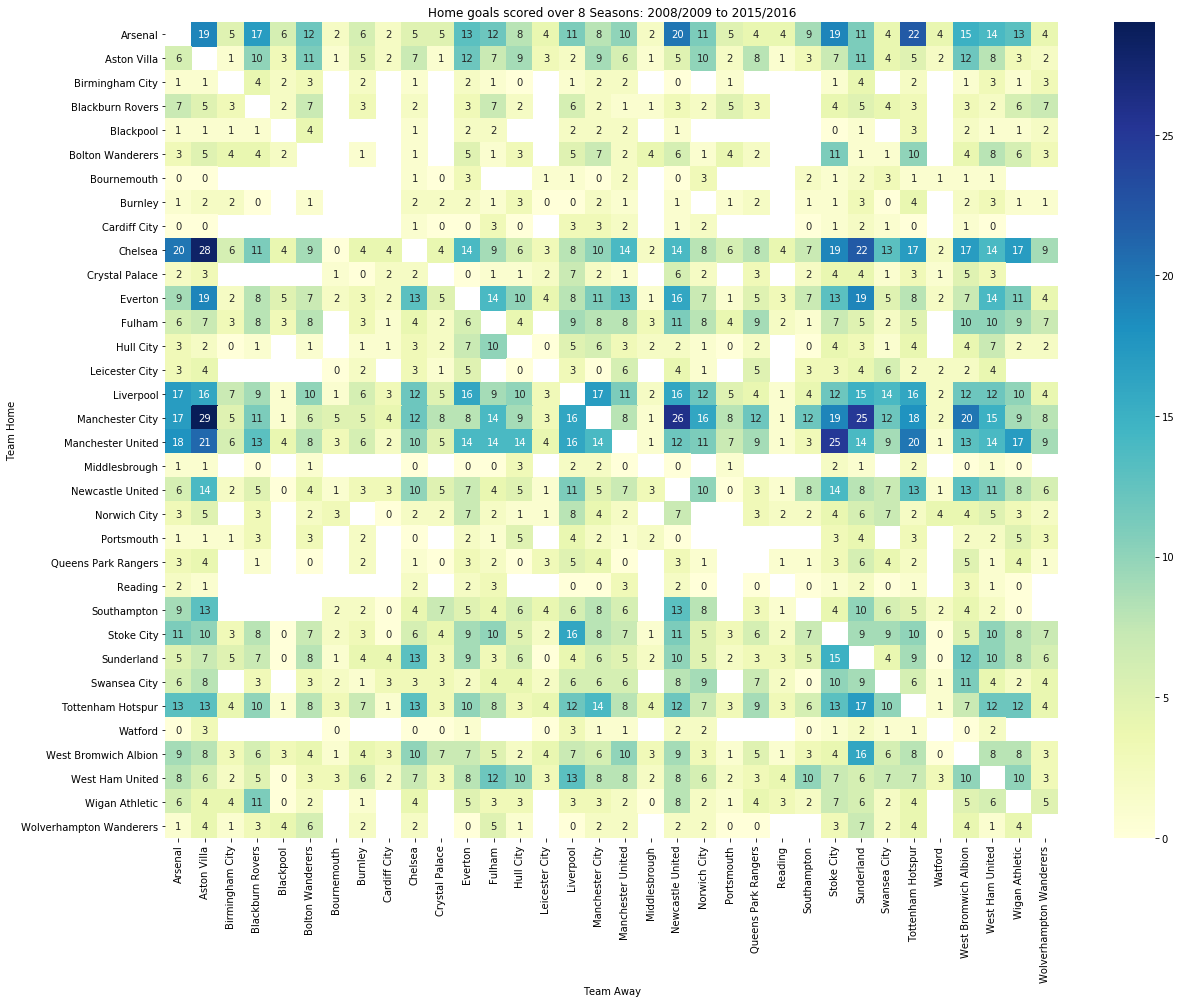

Team_Away         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Home                                                                   
Arsenal               NaN         19.0              5.0              17.0   
Aston Villa           6.0          NaN              1.0              10.0   
Birmingham City       1.0          1.0              NaN               4.0   
Blackburn Rovers      7.0          5.0              3.0               NaN   
Blackpool             1.0          1.0              1.0               1.0   

Team_Away         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Home                                                             
Arsenal                 6.0              12.0          2.0      6.0   
Aston Villa             3.0              11.0          1.0      5.0   
Birmingham City         2.0               3.0          NaN      2.0   
Blackburn Rovers        2.0               7.0          NaN      3.0   
Blackpool               NaN               4.0          NaN      NaN   

Team_Away         Cardiff City  Chelsea           ...             Southampton  \
Team_Home                                         ...                           
Arsenal                    2.0      5.0           ...                     9.0   
Aston Villa                2.0      7.0           ...                     3.0   
Birmingham City            NaN      1.0           ...                     NaN   
Blackburn Rovers           NaN      2.0           ...                     NaN   
Blackpool                  NaN      1.0           ...                     NaN   

Team_Away         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Home                                                                   
Arsenal                 19.0        11.0           4.0               22.0   
Aston Villa              7.0        11.0           4.0                5.0   
Birmingham City          1.0         4.0           NaN                2.0   
Blackburn Rovers         4.0         5.0           4.0                3.0   
Blackpool                0.0         1.0           NaN                3.0   

Team_Away         Watford  West Bromwich Albion  West Ham United  \
Team_Home                                                          
Arsenal               4.0                  15.0             14.0   
Aston Villa           2.0                  12.0              8.0   
Birmingham City       NaN                   1.0              3.0   
Blackburn Rovers      NaN                   3.0              2.0   
Blackpool             NaN                   2.0              1.0   

Team_Away         Wigan Athletic  Wolverhampton Wanderers  
Team_Home                                                  
Arsenal                     13.0                      4.0  
Aston Villa                  3.0                      2.0  
Birmingham City              1.0                      3.0  
Blackburn Rovers             6.0                      7.0  
Blackpool                    1.0                      2.0  

[5 rows x 34 columns]

In [70]:
team_match_home_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', team_match_goal_sum, \
    'Team_Home', 'Team_Away', 'Team_Home_Goal', \
    'Home goals scored over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team Away', 'Team Home', True, True)

team_match_home_goal_sum.head()

## Question 7b: How many goals has each team scored away, against other teams, over all seasons?
## Answer 7b: Away goals scored against other teams

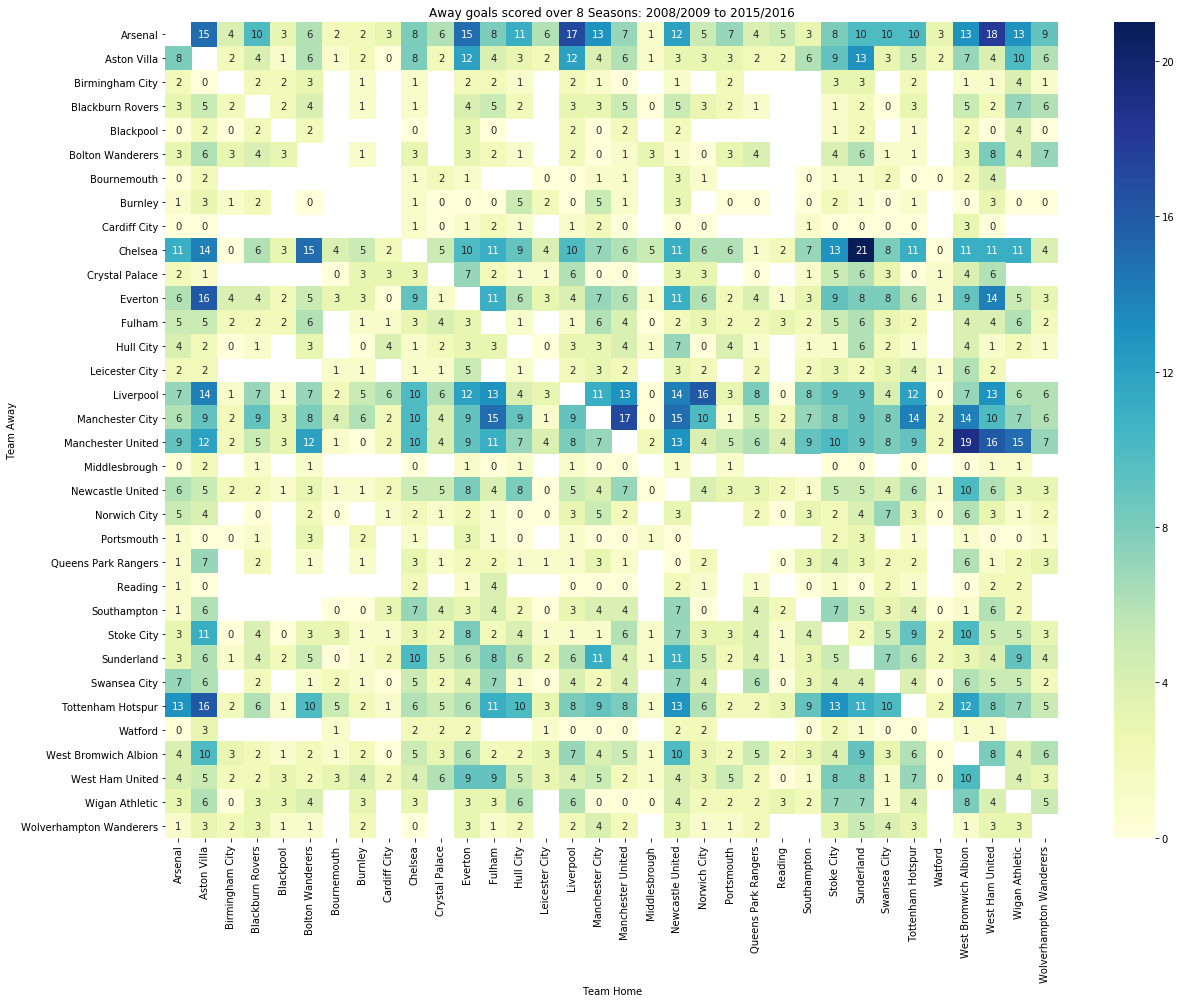

Team_Home         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Away                                                                   
Arsenal               NaN         15.0              4.0              10.0   
Aston Villa           8.0          NaN              2.0               4.0   
Birmingham City       2.0          0.0              NaN               2.0   
Blackburn Rovers      3.0          5.0              2.0               NaN   
Blackpool             0.0          2.0              0.0               2.0   

Team_Home         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Away                                                             
Arsenal                 3.0               6.0          2.0      2.0   
Aston Villa             1.0               6.0          1.0      2.0   
Birmingham City         2.0               3.0          NaN      1.0   
Blackburn Rovers        2.0               4.0          NaN      1.0   
Blackpool               NaN               2.0          NaN      NaN   

Team_Home         Cardiff City  Chelsea           ...             Southampton  \
Team_Away                                         ...                           
Arsenal                    3.0      8.0           ...                     3.0   
Aston Villa                0.0      8.0           ...                     6.0   
Birmingham City            NaN      1.0           ...                     NaN   
Blackburn Rovers           NaN      1.0           ...                     NaN   
Blackpool                  NaN      0.0           ...                     NaN   

Team_Home         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Away                                                                   
Arsenal                  8.0        10.0          10.0               10.0   
Aston Villa              9.0        13.0           3.0                5.0   
Birmingham City          3.0         3.0           NaN                2.0   
Blackburn Rovers         1.0         2.0           0.0                3.0   
Blackpool                1.0         2.0           NaN                1.0   

Team_Home         Watford  West Bromwich Albion  West Ham United  \
Team_Away                                                          
Arsenal               3.0                  13.0             18.0   
Aston Villa           2.0                   7.0              4.0   
Birmingham City       NaN                   1.0              1.0   
Blackburn Rovers      NaN                   5.0              2.0   
Blackpool             NaN                   2.0              0.0   

Team_Home         Wigan Athletic  Wolverhampton Wanderers  
Team_Away                                                  
Arsenal                     13.0                      9.0  
Aston Villa                 10.0                      6.0  
Birmingham City              4.0                      1.0  
Blackburn Rovers             7.0                      6.0  
Blackpool                    4.0                      0.0  

[5 rows x 34 columns]

In [71]:
team_match_away_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', team_match_goal_sum, \
    'Team_Away', 'Team_Home', 'Team_Away_Goal', \
    'Away goals scored over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team Home', 'Team Away', True, True)

team_match_away_goal_sum.head()

## Question 7c: How many goals has each team scored, against other teams, over all seasons
## Answer 7c: Total goals scored against other teams

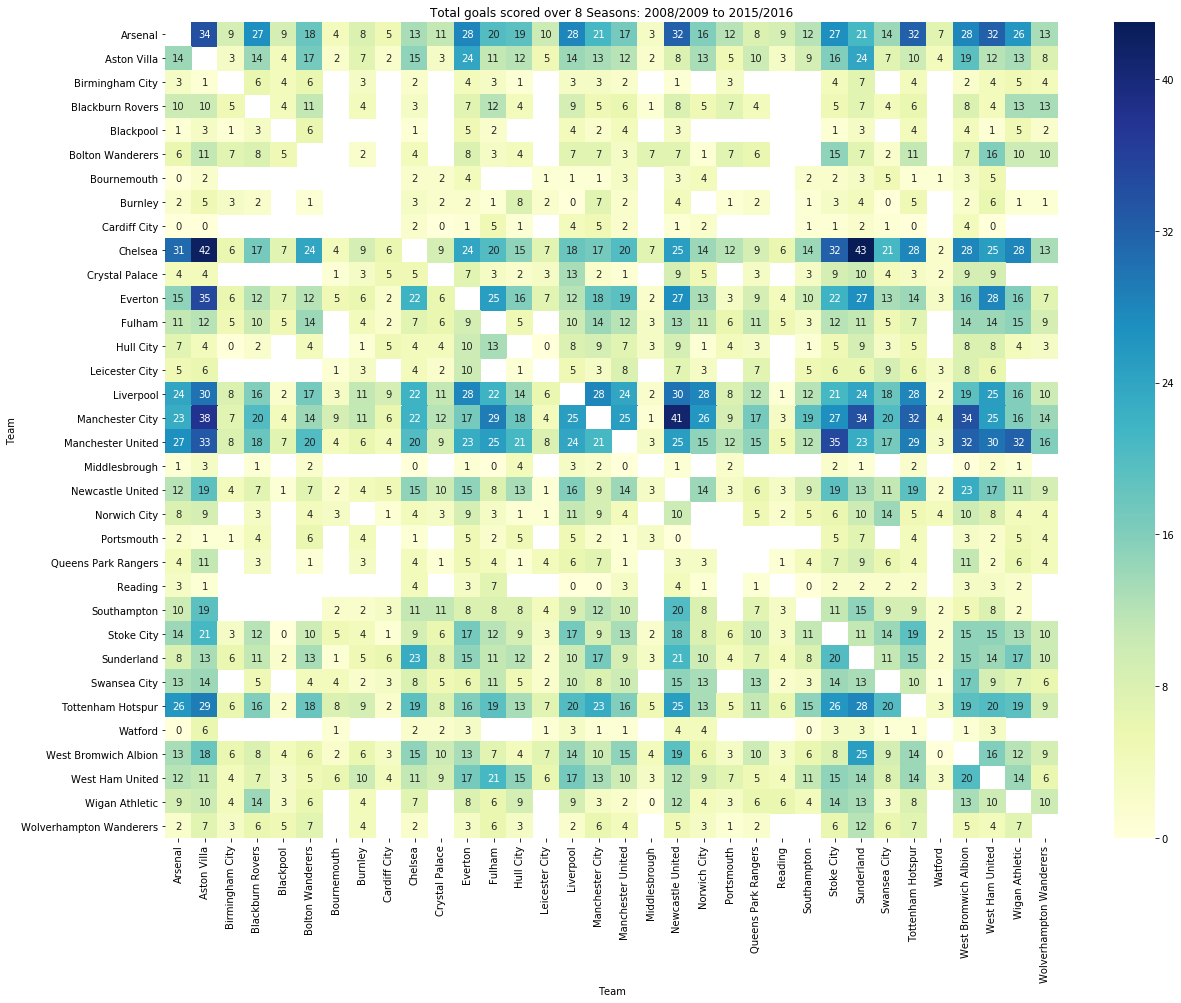

Team_Away         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Home                                                                   
Arsenal               NaN         34.0              9.0              27.0   
Aston Villa          14.0          NaN              3.0              14.0   
Birmingham City       3.0          1.0              NaN               6.0   
Blackburn Rovers     10.0         10.0              5.0               NaN   
Blackpool             1.0          3.0              1.0               3.0   

Team_Away         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Home                                                             
Arsenal                 9.0              18.0          4.0      8.0   
Aston Villa             4.0              17.0          2.0      7.0   
Birmingham City         4.0               6.0          NaN      3.0   
Blackburn Rovers        4.0              11.0          NaN      4.0   
Blackpool               NaN               6.0          NaN      NaN   

Team_Away         Cardiff City  Chelsea           ...             Southampton  \
Team_Home                                         ...                           
Arsenal                    5.0     13.0           ...                    12.0   
Aston Villa                2.0     15.0           ...                     9.0   
Birmingham City            NaN      2.0           ...                     NaN   
Blackburn Rovers           NaN      3.0           ...                     NaN   
Blackpool                  NaN      1.0           ...                     NaN   

Team_Away         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Home                                                                   
Arsenal                 27.0        21.0          14.0               32.0   
Aston Villa             16.0        24.0           7.0               10.0   
Birmingham City          4.0         7.0           NaN                4.0   
Blackburn Rovers         5.0         7.0           4.0                6.0   
Blackpool                1.0         3.0           NaN                4.0   

Team_Away         Watford  West Bromwich Albion  West Ham United  \
Team_Home                                                          
Arsenal               7.0                  28.0             32.0   
Aston Villa           4.0                  19.0             12.0   
Birmingham City       NaN                   2.0              4.0   
Blackburn Rovers      NaN                   8.0              4.0   
Blackpool             NaN                   4.0              1.0   

Team_Away         Wigan Athletic  Wolverhampton Wanderers  
Team_Home                                                  
Arsenal                     26.0                     13.0  
Aston Villa                 13.0                      8.0  
Birmingham City              5.0                      4.0  
Blackburn Rovers            13.0                     13.0  
Blackpool                    5.0                      2.0  

[5 rows x 34 columns]

In [72]:
team_match_total_goal_sum = team_match_home_goal_sum + team_match_away_goal_sum

team_match_total_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', team_match_total_goal_sum, \
    '', '', '', \
    'Total goals scored over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team', 'Team', False, False)

team_match_total_goal_sum.head()

## Question 8a: How many goals has each team allowed home, from other teams, over all seasons?
## Answer 8a: Home goals allowed from other teams

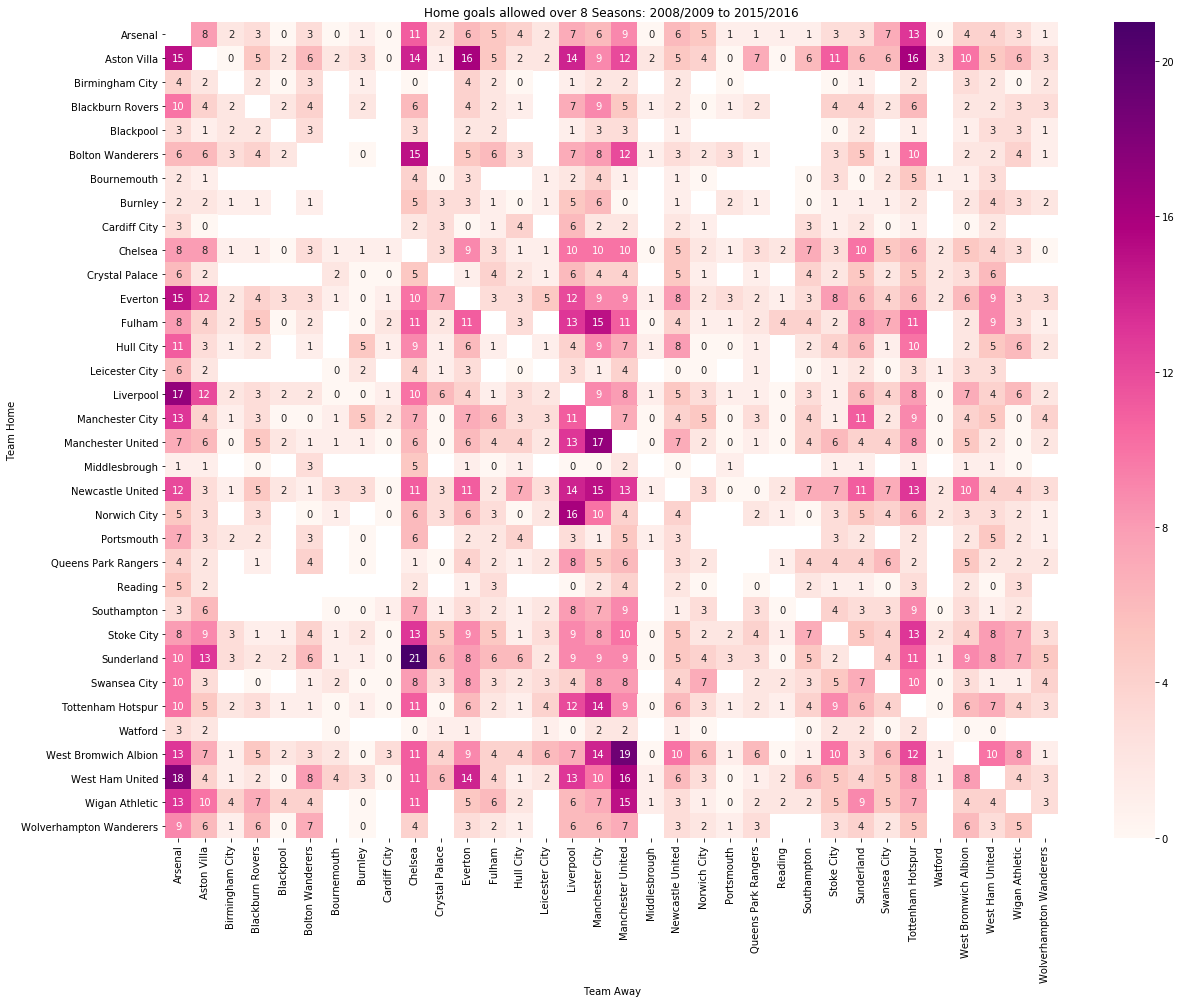

Team_Away         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Home                                                                   
Arsenal               NaN          8.0              2.0               3.0   
Aston Villa          15.0          NaN              0.0               5.0   
Birmingham City       4.0          2.0              NaN               2.0   
Blackburn Rovers     10.0          4.0              2.0               NaN   
Blackpool             3.0          1.0              2.0               2.0   

Team_Away         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Home                                                             
Arsenal                 0.0               3.0          0.0      1.0   
Aston Villa             2.0               6.0          2.0      3.0   
Birmingham City         0.0               3.0          NaN      1.0   
Blackburn Rovers        2.0               4.0          NaN      2.0   
Blackpool               NaN               3.0          NaN      NaN   

Team_Away         Cardiff City  Chelsea           ...             Southampton  \
Team_Home                                         ...                           
Arsenal                    0.0     11.0           ...                     1.0   
Aston Villa                0.0     14.0           ...                     6.0   
Birmingham City            NaN      0.0           ...                     NaN   
Blackburn Rovers           NaN      6.0           ...                     NaN   
Blackpool                  NaN      3.0           ...                     NaN   

Team_Away         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Home                                                                   
Arsenal                  3.0         3.0           7.0               13.0   
Aston Villa             11.0         6.0           6.0               16.0   
Birmingham City          0.0         1.0           NaN                2.0   
Blackburn Rovers         4.0         4.0           2.0                6.0   
Blackpool                0.0         2.0           NaN                1.0   

Team_Away         Watford  West Bromwich Albion  West Ham United  \
Team_Home                                                          
Arsenal               0.0                   4.0              4.0   
Aston Villa           3.0                  10.0              5.0   
Birmingham City       NaN                   3.0              2.0   
Blackburn Rovers      NaN                   2.0              2.0   
Blackpool             NaN                   1.0              3.0   

Team_Away         Wigan Athletic  Wolverhampton Wanderers  
Team_Home                                                  
Arsenal                      3.0                      1.0  
Aston Villa                  6.0                      3.0  
Birmingham City              0.0                      2.0  
Blackburn Rovers             3.0                      3.0  
Blackpool                    3.0                      1.0  

[5 rows x 34 columns]

In [73]:
team_match_home_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', team_match_goal_sum, \
    'Team_Home', 'Team_Away', 'Team_Away_Goal', \
    'Home goals allowed over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team Away', 'Team Home', True, True)

team_match_home_allowed_sum.head()

## Question 8b: How many goals has each team allowed away, from other teams, over all seasons?
## Answer 8b: Away goals allowed from other teams

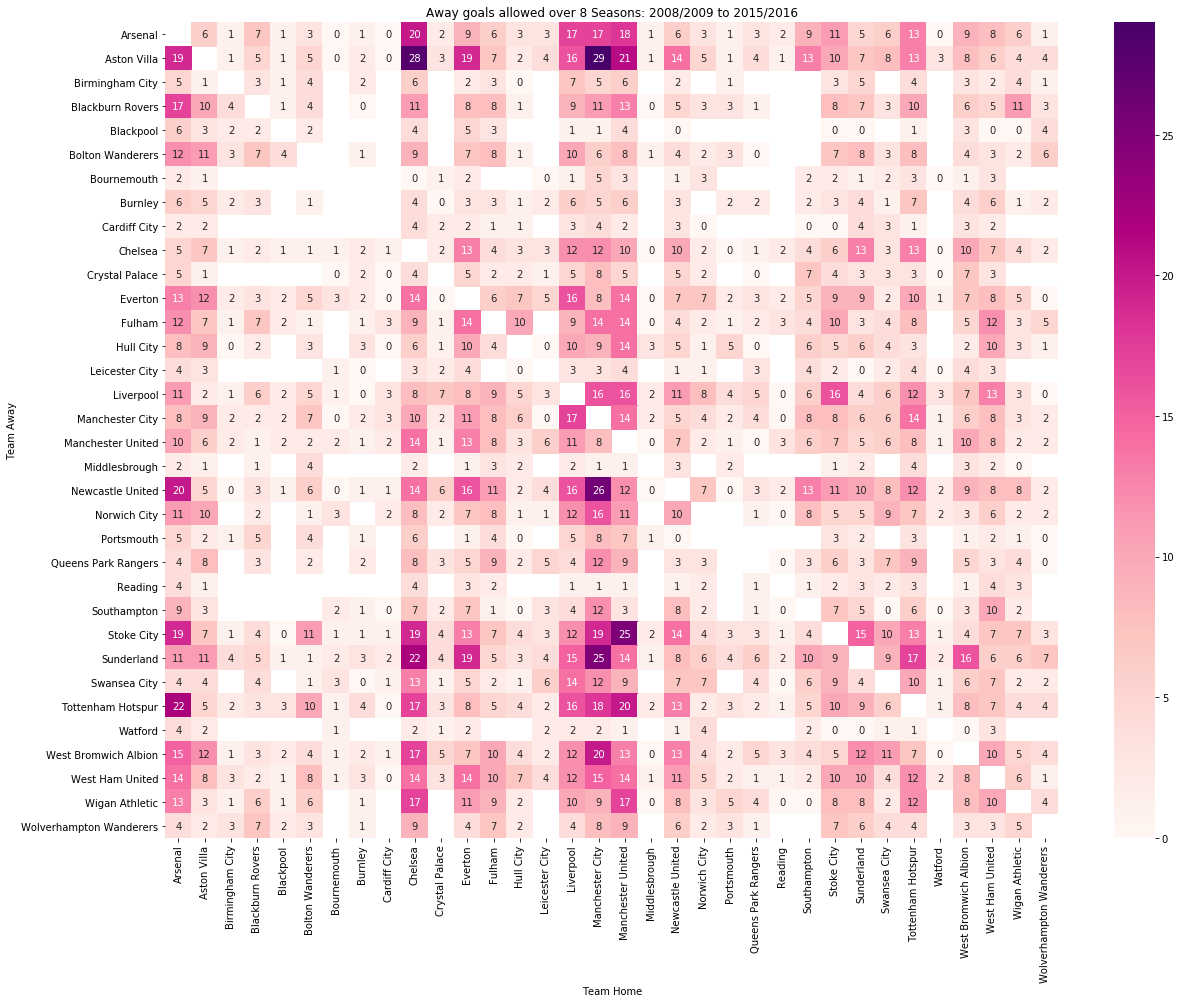

Team_Home         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Away                                                                   
Arsenal               NaN          6.0              1.0               7.0   
Aston Villa          19.0          NaN              1.0               5.0   
Birmingham City       5.0          1.0              NaN               3.0   
Blackburn Rovers     17.0         10.0              4.0               NaN   
Blackpool             6.0          3.0              2.0               2.0   

Team_Home         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Away                                                             
Arsenal                 1.0               3.0          0.0      1.0   
Aston Villa             1.0               5.0          0.0      2.0   
Birmingham City         1.0               4.0          NaN      2.0   
Blackburn Rovers        1.0               4.0          NaN      0.0   
Blackpool               NaN               2.0          NaN      NaN   

Team_Home         Cardiff City  Chelsea           ...             Southampton  \
Team_Away                                         ...                           
Arsenal                    0.0     20.0           ...                     9.0   
Aston Villa                0.0     28.0           ...                    13.0   
Birmingham City            NaN      6.0           ...                     NaN   
Blackburn Rovers           NaN     11.0           ...                     NaN   
Blackpool                  NaN      4.0           ...                     NaN   

Team_Home         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Away                                                                   
Arsenal                 11.0         5.0           6.0               13.0   
Aston Villa             10.0         7.0           8.0               13.0   
Birmingham City          3.0         5.0           NaN                4.0   
Blackburn Rovers         8.0         7.0           3.0               10.0   
Blackpool                0.0         0.0           NaN                1.0   

Team_Home         Watford  West Bromwich Albion  West Ham United  \
Team_Away                                                          
Arsenal               0.0                   9.0              8.0   
Aston Villa           3.0                   8.0              6.0   
Birmingham City       NaN                   3.0              2.0   
Blackburn Rovers      NaN                   6.0              5.0   
Blackpool             NaN                   3.0              0.0   

Team_Home         Wigan Athletic  Wolverhampton Wanderers  
Team_Away                                                  
Arsenal                      6.0                      1.0  
Aston Villa                  4.0                      4.0  
Birmingham City              4.0                      1.0  
Blackburn Rovers            11.0                      3.0  
Blackpool                    0.0                      4.0  

[5 rows x 34 columns]

In [74]:
team_match_away_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', team_match_goal_sum, \
    'Team_Away', 'Team_Home', 'Team_Home_Goal', \
    'Away goals allowed over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team Home', 'Team Away', True, True)

team_match_away_allowed_sum.head()

## Question 8c: How many goals has each team allowed, from other teams, over all seasons
## Answer 8c: Total goals allowed from other teams

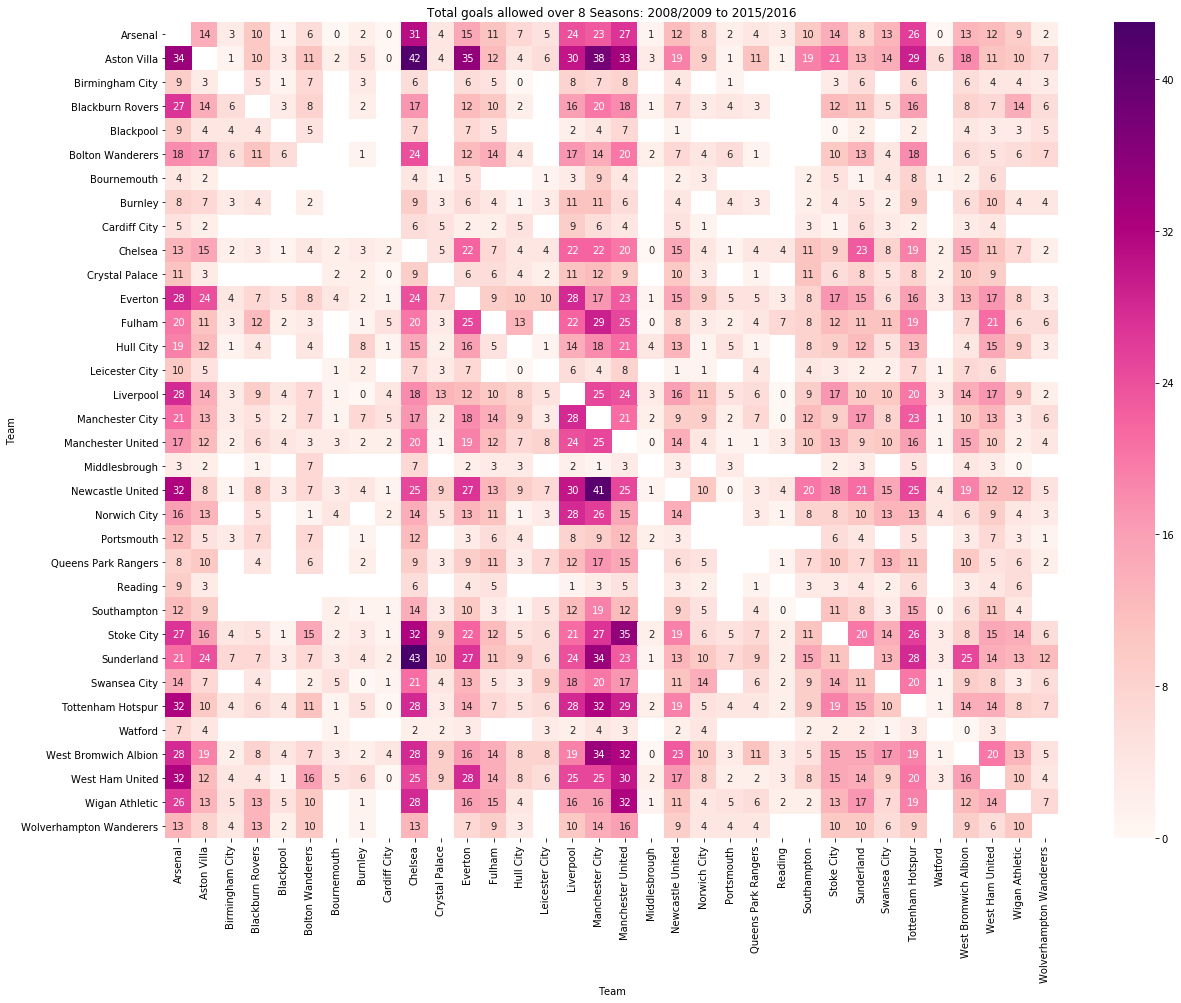

Team_Away         Arsenal  Aston Villa  Birmingham City  Blackburn Rovers  \
Team_Home                                                                   
Arsenal               NaN         14.0              3.0              10.0   
Aston Villa          34.0          NaN              1.0              10.0   
Birmingham City       9.0          3.0              NaN               5.0   
Blackburn Rovers     27.0         14.0              6.0               NaN   
Blackpool             9.0          4.0              4.0               4.0   

Team_Away         Blackpool  Bolton Wanderers  Bournemouth  Burnley  \
Team_Home                                                             
Arsenal                 1.0               6.0          0.0      2.0   
Aston Villa             3.0              11.0          2.0      5.0   
Birmingham City         1.0               7.0          NaN      3.0   
Blackburn Rovers        3.0               8.0          NaN      2.0   
Blackpool               NaN               5.0          NaN      NaN   

Team_Away         Cardiff City  Chelsea           ...             Southampton  \
Team_Home                                         ...                           
Arsenal                    0.0     31.0           ...                    10.0   
Aston Villa                0.0     42.0           ...                    19.0   
Birmingham City            NaN      6.0           ...                     NaN   
Blackburn Rovers           NaN     17.0           ...                     NaN   
Blackpool                  NaN      7.0           ...                     NaN   

Team_Away         Stoke City  Sunderland  Swansea City  Tottenham Hotspur  \
Team_Home                                                                   
Arsenal                 14.0         8.0          13.0               26.0   
Aston Villa             21.0        13.0          14.0               29.0   
Birmingham City          3.0         6.0           NaN                6.0   
Blackburn Rovers        12.0        11.0           5.0               16.0   
Blackpool                0.0         2.0           NaN                2.0   

Team_Away         Watford  West Bromwich Albion  West Ham United  \
Team_Home                                                          
Arsenal               0.0                  13.0             12.0   
Aston Villa           6.0                  18.0             11.0   
Birmingham City       NaN                   6.0              4.0   
Blackburn Rovers      NaN                   8.0              7.0   
Blackpool             NaN                   4.0              3.0   

Team_Away         Wigan Athletic  Wolverhampton Wanderers  
Team_Home                                                  
Arsenal                      9.0                      2.0  
Aston Villa                 10.0                      7.0  
Birmingham City              4.0                      3.0  
Blackburn Rovers            14.0                      6.0  
Blackpool                    3.0                      5.0  

[5 rows x 34 columns]

In [75]:
team_match_total_allowed_sum = team_match_home_allowed_sum + team_match_away_allowed_sum

team_match_total_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', team_match_total_allowed_sum, \
    '', '', '', \
    'Total goals allowed over '+str(unique_seasons.size)+' Seasons: '+unique_seasons.iloc[0]+' to '+unique_seasons.iloc[-1], \
    'Team', 'Team', False, False)

team_match_total_allowed_sum.head()

## Apart from individual goals scored or allowed, let us consider a match outcome in terms of win (more goals scored), tie (no goals or equal goals scored) or loss (rival team scored more goals) for each team.

In [76]:
#apply() is needed to announce win, tie or loss


## Try it on your own! Feel free to take a deep dive into another Country and League
## Simply go to cell 8 above where we defined our query to our local sqlite database and change the Country and League name filters to your own favorites.
...  
Country = 'Spain' AND  
League.name = 'Spain LIGA BBVA'  
...  
## Everything until this point will work regardless of which Country and League you selected.
## The remaining short part applies only to the Spanish BBVA League. As a reminder, you can adopt it to your own rival teams within your favorite League.

## El Clásico
## El Clásico is the name given in football to any match between fierce rivals FC Barcelona and Real Madrid.
## https://en.wikipedia.org/wiki/El_Clásico

## All El Clásico matches in our dataset

In [77]:
FCB = 'FC Barcelona'
RMCF = 'Real Madrid CF'
spain_liga_bbva_df[((spain_liga_bbva_df['Team_Home'] == FCB) & (spain_liga_bbva_df['Team_Away'] == RMCF)) \
                  | ((spain_liga_bbva_df['Team_Home'] == RMCF) & (spain_liga_bbva_df['Team_Away'] == FCB))]

Empty DataFrame
Columns: [Country, League, Season, Date, Team_Home, Team_Away, Team_Home_Goal, Team_Away_Goal]
Index: []

## Match outcomes when 'FC Barcelona' played at home (see corresponding graph and questions 7a, 8a above)

In [78]:
spain_liga_bbva_df[((spain_liga_bbva_df['Team_Home'] == FCB) & (spain_liga_bbva_df['Team_Away'] == RMCF)) ][['Team_Home_Goal','Team_Away_Goal']].sum()

Team_Home_Goal   NaN
Team_Away_Goal   NaN
dtype: float64

## Match outcomes when 'Real Madrid CF' played at home (see corresponding graph and questions 7b, 8b above)

In [79]:
spain_liga_bbva_df[((spain_liga_bbva_df['Team_Home'] == RMCF) & (spain_liga_bbva_df['Team_Away'] == FCB)) ][['Team_Home_Goal','Team_Away_Goal']].sum()

Team_Home_Goal   NaN
Team_Away_Goal   NaN
dtype: float64

## Additional Material - Appendix

## Matplotlib colormap reference  
https://matplotlib.org/examples/color/colormaps_reference.html
## Personal favorites for displaying positive impact: 'YlGnBu', 'cool'
## Personal favorites for displaying negative impact: 'RdPu', 'magma_r', 'plasma_r'

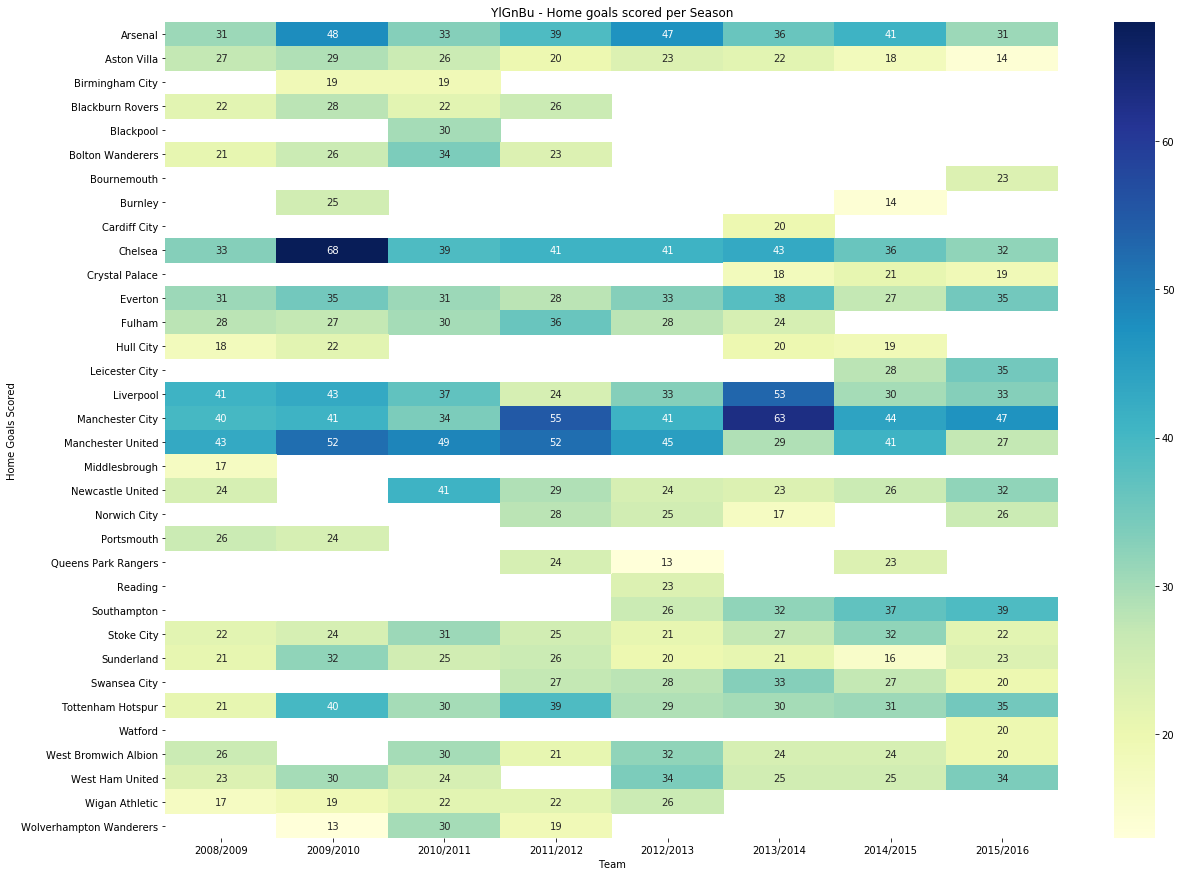

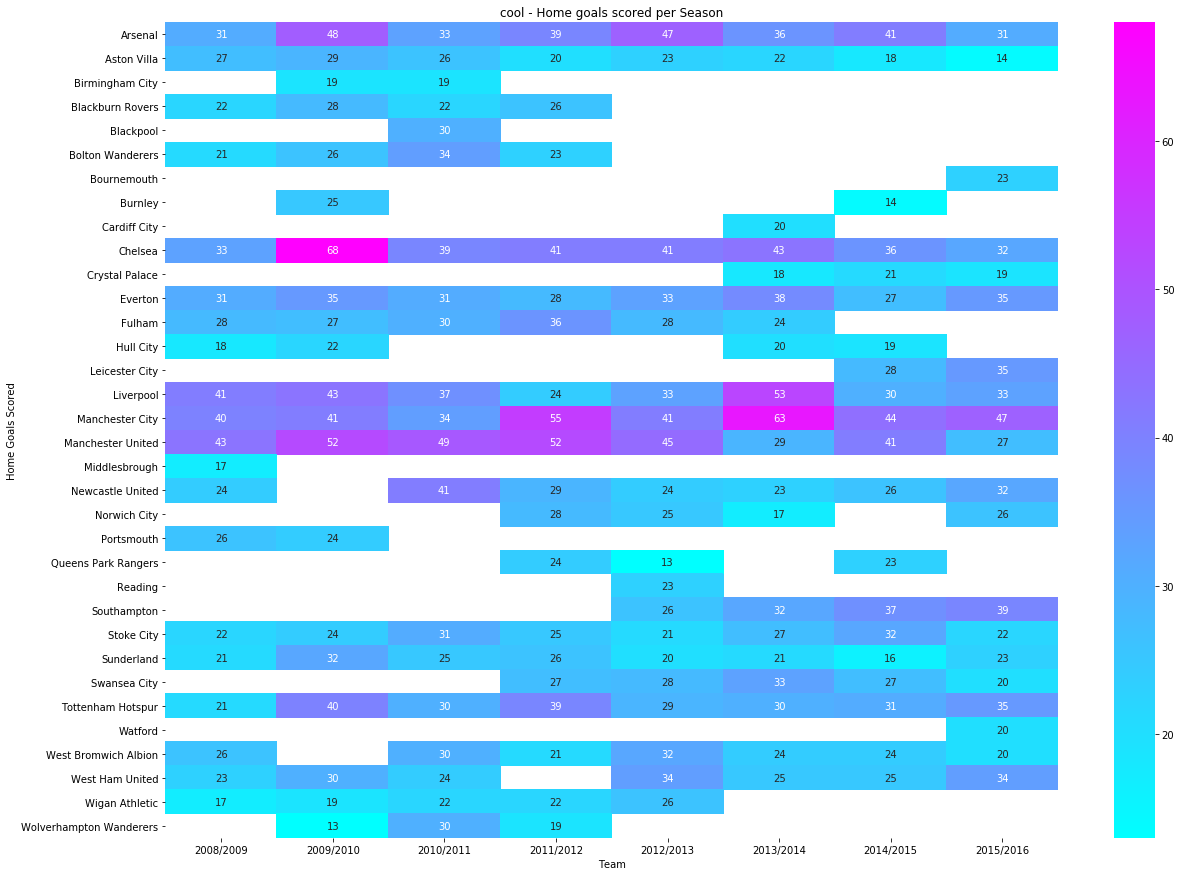

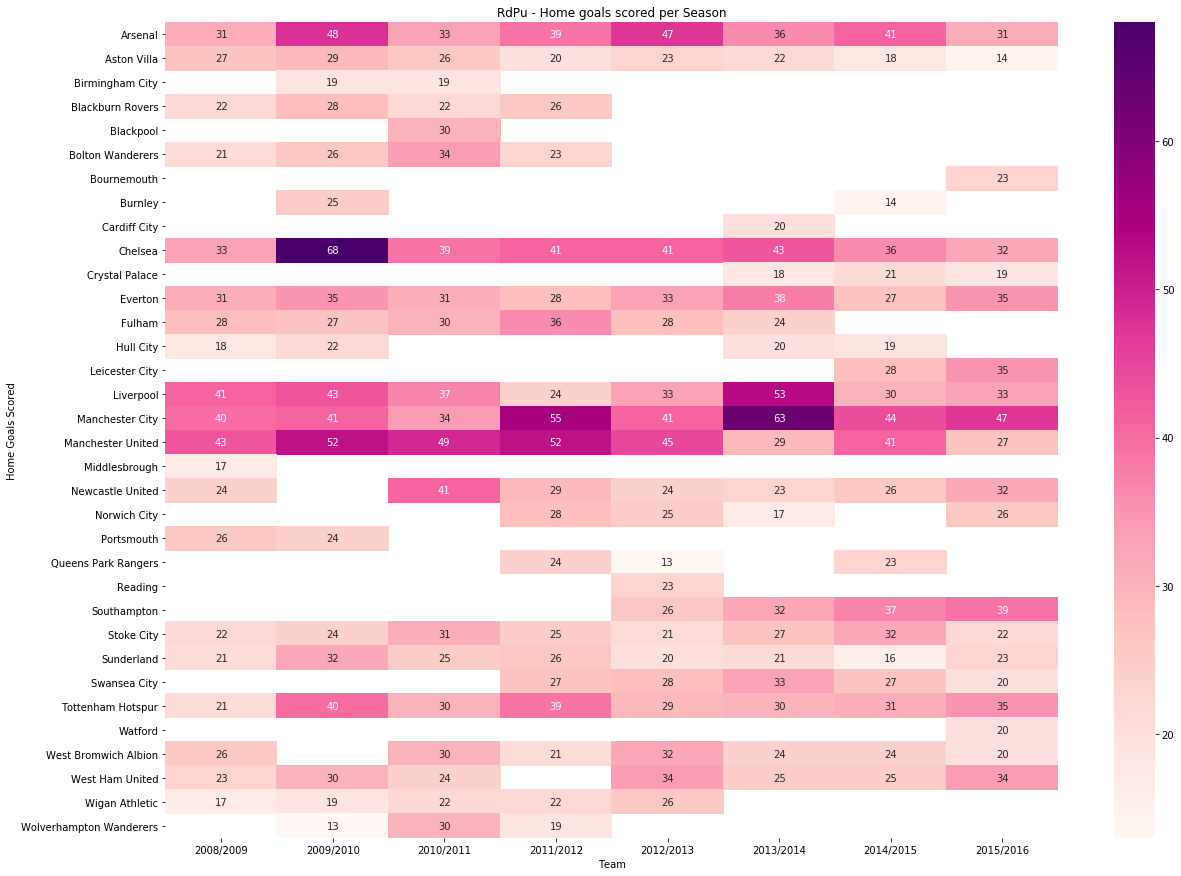

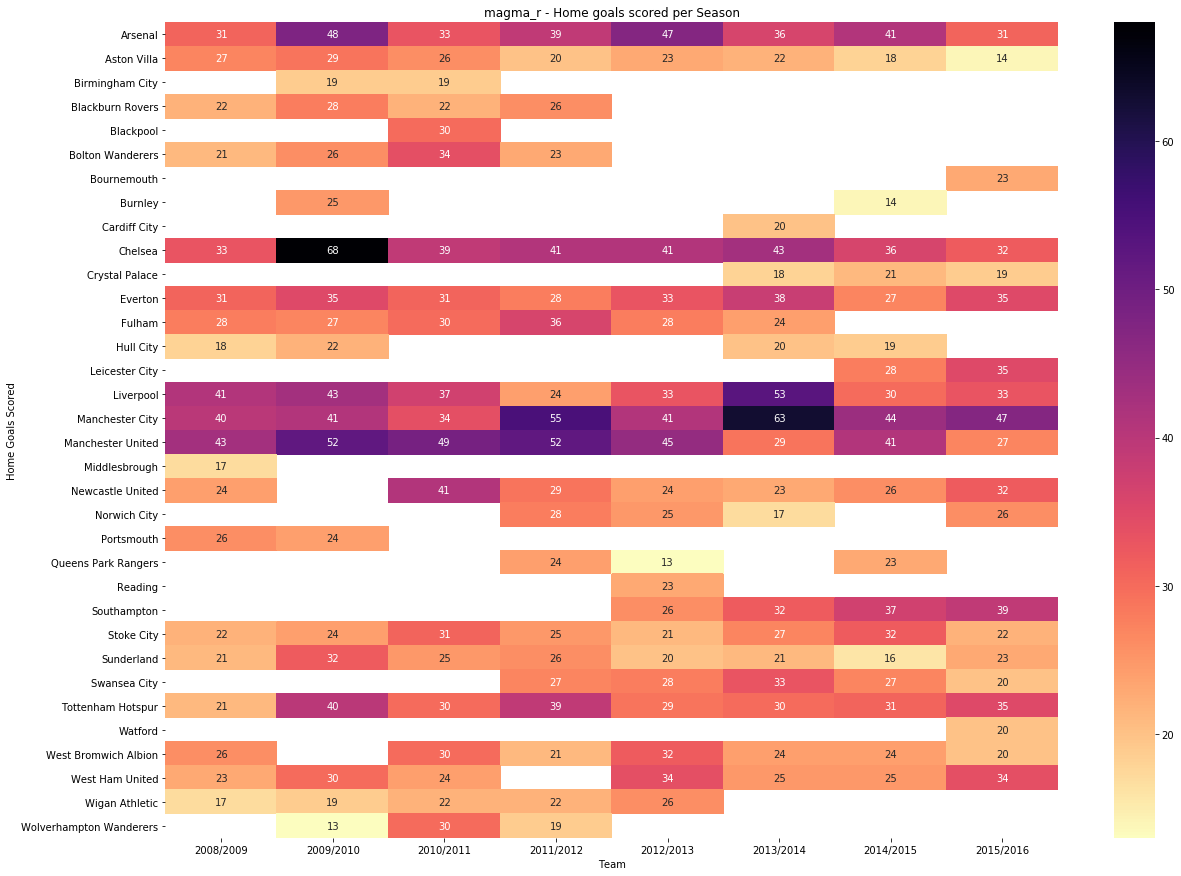

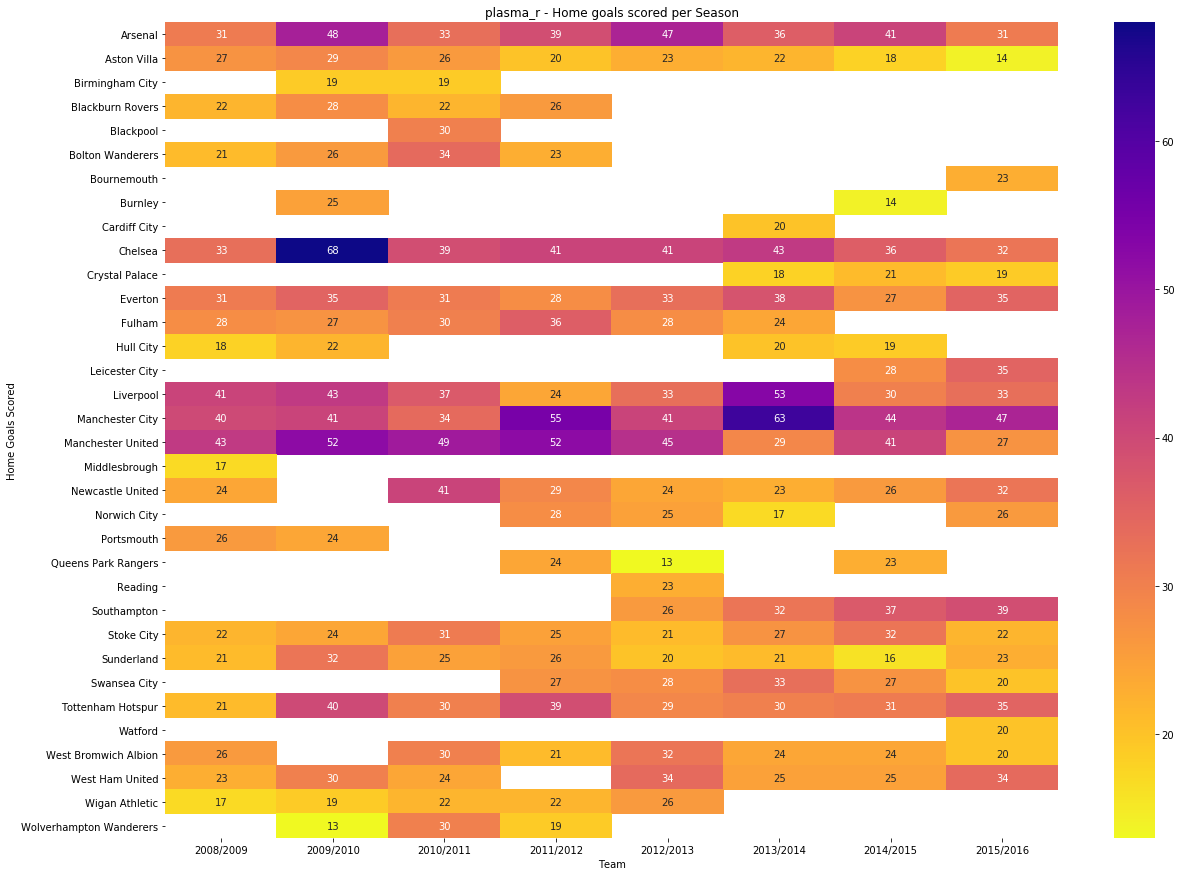

In [80]:
#plot_colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
plot_colors = ['YlGnBu', 'cool', 'RdPu', 'magma_r', 'plasma_r']

for plot_color in plot_colors:
    season_team_home_goal_sum = reset_index_pivot_plot_series('heat_map', plot_color, season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', plot_color + ' - Home goals scored per Season', 'Team', 'Home Goals Scored', False, False)